#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import scipy
from numpy import linalg as LA

In [3]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [4]:
# from diffeqpy import ode
# from diffeqpy import de

In [5]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [6]:
from sympy import *

In [7]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [8]:
mp = 96 #  (submerged) [kg/m]

In [9]:
node_N=4

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
# diag_Irho = 1e30*np.array([1, 1, 2]) # [m^4]  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
 
Irho=np.diag(diag_Irho)

In [11]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [13]:
diag_DT = 1.5*np.array([1, 1, 1]) # [N/m]  , p.99 in [1]

In [14]:
DT=np.diag(diag_DT) # (35) in [2]

In [15]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [16]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [17]:
CT=np.diag(diag_CT)

In [18]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [19]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [20]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [21]:
rng = np.random.default_rng()

In [22]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [23]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [24]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.78563581,  0.60676506,  0.12088235],
       [-0.60338145,  0.7946241 , -0.06710714],
       [-0.13677429, -0.0202164 ,  0.99039593]])

In [25]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.002722


In [26]:
Ret

array([[[ 0.78563581,  0.60676506,  0.12088235],
        [-0.60338145,  0.7946241 , -0.06710714],
        [-0.13677429, -0.0202164 ,  0.99039593]],

       [[-0.58396868, -0.23798898,  0.77610684],
        [-0.80509924,  0.29216466, -0.51619281],
        [-0.10390279, -0.92628346, -0.36221976]],

       [[-0.30952007,  0.92422301, -0.22362725],
        [-0.15606663, -0.28136252, -0.9468254 ],
        [-0.93799815, -0.25816071,  0.23132771]],

       [[ 0.53156692, -0.56486465, -0.63116126],
        [ 0.80312328,  0.57288873,  0.16368112],
        [ 0.26912749, -0.59390777,  0.75818464]]])

In [27]:
Ret.shape

(4, 3, 3)

In [28]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [29]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
    ans=np.einsum('ijk,ik->ij', Ret, np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))) 
    return ans.T

In [30]:
dx**2

array([0.01417768, 0.54549988, 1.66995785, 0.1225676 ])

In [31]:
C1(dx,dy,dz,Ret)

array([[-1.96997409, -1.39974978, -1.64959576, -1.44282883],
       [-0.23854452,  0.3672956 ,  1.75006116, -0.47113988],
       [-1.08804209,  1.27025825,  1.93978877, -0.53351301]])

In [32]:
C1(dx,dy,dz,Ret).shape

(3, 4)

In [33]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000358


In [34]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [35]:
1/2*d0*qw*np.dot(DT,C1(dx,dy,dz,Ret).T[0])*9.81

array([-11305.74814072,  -1369.01506857,  -6244.31045654])

In [36]:
fD(dx,dy,dz,DT,Ret)

array([[-11305.74814072,  -8033.2114657 ,  -9467.08603   ,
         -8280.44364881],
       [ -1369.01506857,   2107.92190525,  10043.66041664,
         -2703.88774442],
       [ -6244.31045654,   7290.0552033 ,  11132.51356646,
         -3061.84925526]])

In [37]:
fD(dx,dy,dz,DT,Ret).T

array([[-11305.74814072,  -1369.01506857,  -6244.31045654],
       [ -8033.2114657 ,   2107.92190525,   7290.0552033 ],
       [ -9467.08603   ,  10043.66041664,  11132.51356646],
       [ -8280.44364881,  -2703.88774442,  -3061.84925526]])

In [38]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.001089


In [39]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [40]:
I=np.identity(3)

In [41]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000439


In [42]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [43]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [44]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [45]:
DR=np.diag(diag_DR) 

In [46]:
dI= 0.69# Inner diameter of pipe, [m]

In [47]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [51]:
# # not checked 
# def k_sigma(hi,d0,fg_e):
#     ans=[]
#     for it in hi:
#         if it<0:
#             ans.append(0)
#         elif 0<=it<=d0/20:
#             ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
#         else:
#             ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))     
#     return np.array(ans).reshape(node_N,1)   

In [52]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [53]:
# # not checked
# def hi(x,y,z,d0):
#     return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [54]:
# startTime1 = datetime.now()
# hi(x,y,z,d0)
# print(datetime.now() - startTime1)

In [55]:
# k_sigma(hi(x,y,z,d0),d0,fg_e)

In [56]:
# startTime1 = datetime.now()
# k_sigma(hi(x,y,z,d0),d0,fg_e)
# print(datetime.now() - startTime1)

In [57]:
# # TODO: force shoud be acting only at nodes that are in contact with the seabed
# # not checked
# def sigma(x,y,z):
#     return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [58]:
# startTime1 = datetime.now()
# sigma(x,y,z)
# print(datetime.now() - startTime1)

In [59]:
def Re_b(Ret):
#     return np.dot(Ret, Rb_t ) # (5) in[3]
    return Ret

In [60]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000296


In [61]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [62]:
phi(x,y,z,Ret,None)

array([[ 180.31555114,   85.88136523,   32.36345964],
       [  20.92376744,  106.16170316,  -57.2726204 ],
       [  59.19383456,  -54.7724252 ,    3.54904473],
       [  25.09696411,  104.45795341, -311.24663154]])

In [63]:
# def d_s(da,db,dc,x,y,z):

#     ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
#                  +np.diff(z,prepend=z[0])**2)
#     ds[ds == 0] = 1
#     return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [64]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.000298


In [65]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [66]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [67]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000797


In [68]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [69]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.000767


In [70]:
ωe(φ,θ,ψ,None,None)

array([[-0.01215634,  0.16563678, -0.65949806],
       [ 0.43217861,  1.93634739,  0.88439943],
       [ 1.39798125,  1.61430378, -0.14043789],
       [-0.66820125, -0.51090492,  0.48429614]])

In [71]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    K=np.apply_along_axis(S, 1, omega)
#     print('fun',fun)
#     print('K',K)
#     print('ans',np.einsum('ijk,ik->ij',K,fun).T)

    return np.einsum('ijk,ik->ij',K,fun.astype(np.float32)).T



In [72]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[  61.99917121, -204.78904147,   -1.96288739,  108.42885739],
       [-118.5243347 ,   43.25696925,  -13.27455546, -195.82103378],
       [ -30.91088979,    5.36513602, -172.12765859,  -56.97677355]])

In [73]:
# def d_s(f,a,b,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(b,prepend=b[0])**2
# #                  +np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(b)**2+np.diff(c)**2)
#     ds[ds == 0] = 1
#     fun = f(a,b,c,Ret)
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     return np.insert(ans, -1, 0.8*ans[:,-1], axis=1)

In [74]:
# def d_s(f,a,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(c)**2)
# #     ds[ds == 0] = 1
#     fun = f(a,c,Ret)
# #     ans=(np.diff(fun,prepend=fun[0].reshape(1,2),axis=0) / ds.reshape(node_N,1)).T
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     np.insert(ans, -1, ans[:,-1], axis=1)
#     return np.insert(ans, -1, 1.1*ans[:,-1], axis=1)

In [75]:
# d_s(phi,x,y,z,Ret)

In [76]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001126


In [77]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B-
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze())

In [78]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [79]:
# sigma(x,y,z)

In [80]:
ne_(dx,dy,dz,DT,Ret)

array([[ 11305.74814072,   8033.2114657 ,   9467.08603   ,
          8280.44364881],
       [  1369.01506857,  -2107.92190525, -10043.66041664,
          2703.88774442],
       [  6116.14591431,  -7418.21974553, -11260.67810869,
          2933.68471303]])

In [81]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [82]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.000562


In [83]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 3.77824397e+10, -7.44585275e+10, -3.01858405e+10],
       [-6.96378963e+10,  3.76114663e+09,  7.17555175e+08],
       [-1.58397008e+08, -1.03852338e+09, -9.16078876e+09],
       [ 3.04878244e+10, -6.45323441e+10, -3.29074609e+10]])

In [84]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000955


In [85]:
Re_b(Ret).shape

(4, 3, 3)

In [86]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans
#     tmp=[1 for i in range(node_N)]
#     tmp[-1]=1e13
#     print(ans)
#     return ans*np.array(tmp).reshape(node_N,1)
#     return np.einsum("ijk,ip->ijk", ans, np.array(tmp).reshape(node_N,1))

In [87]:
Irho_e(Ret)

array([[[ 61.72236185,   0.        ,   0.        ],
        [  0.        ,  63.14274578,   0.        ],
        [  0.        ,   0.        , 196.17681805]],

       [[ 34.1019416 ,   0.        ,   0.        ],
        [  0.        ,   8.53601908,   0.        ],
        [  0.        ,   0.        ,  26.24063139]],

       [[  9.58026731,   0.        ,   0.        ],
        [  0.        ,   7.91648656,   0.        ],
        [  0.        ,   0.        ,  10.70250222]],

       [[ 28.25633929,   0.        ,   0.        ],
        [  0.        ,  32.82014932,   0.        ],
        [  0.        ,   0.        , 114.96879086]]])

In [88]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000227


In [89]:
# def Π_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
#     return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
#                   [0,1,-np.sin(φ)],
#                   [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [90]:
# def Π(a,b,c):
#     xyz=np.stack((a,b,c), axis=1)
  
#     return np.apply_along_axis(Π_, 1, xyz)
    

In [91]:
# startTime1 = datetime.now()
# Π(φ,θ,ψ).shape
# print(datetime.now() - startTime1)

In [92]:
# def ωe(φ,θ,ψ, dummy):  # (100) in [2]
#     A=Π(φ,θ,ψ)
#     B=np.vstack([φ,θ,ψ])
#     return np.einsum('ijk,ik->ij',A,B.T)

In [93]:
# startTime1 = datetime.now()
# ωe(φ,θ,ψ,None)
# print(datetime.now() - startTime1)

In [94]:
# ωe(φ,θ,ψ,None)

In [95]:
diag_CR = 1e11*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [96]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [97]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega.astype(np.float32))
 
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [98]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.006129


In [99]:
d_me_

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [100]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [101]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [102]:
ne_(dx,dy,dz,DT,Ret)

array([[ 11305.74814072,   8033.2114657 ,   9467.08603   ,
          8280.44364881],
       [  1369.01506857,  -2107.92190525, -10043.66041664,
          2703.88774442],
       [  6116.14591431,  -7418.21974553, -11260.67810869,
          2933.68471303]])

In [103]:
C=ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [104]:
Re_b(Ret).shape

(4, 3, 3)

In [105]:
ne_(dx,dy,dz,DT, Ret).T

array([[ 11305.74814072,   1369.01506857,   6116.14591431],
       [  8033.2114657 ,  -2107.92190525,  -7418.21974553],
       [  9467.08603   , -10043.66041664, -11260.67810869],
       [  8280.44364881,   2703.88774442,   2933.68471303]])

In [106]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([176.99831279,  79.08775587,  69.20299093, 230.51818669]),
 array([  48.08635205,  -17.81555286,   39.44356273, -234.7248485 ]),
 array([-0.11907008,  0.73857964,  1.29226849,  0.35009656]),
 numpy.ndarray,
 array([-0.89572735,  0.96496398,  1.57754142,  1.01053309]))

In [107]:
ne_(dx,dy,dz,DT,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(dx,dy,dz,DT,Ret).T.astype(np.float32))

array([[ 21757.9531789 ,  -4775.24830397,  10599.53975203],
       [ -1913.60127291,  -5362.08296802,  -3613.33387672],
       [  -227.55454621,   1966.64863723, -20152.81559347],
       [  9303.09466467,  11383.32014036,   5780.59455906]])

In [108]:
ne_(dx,dy,dz,DT,Ret).T

array([[ 11305.74814072,   1369.01506857,   6116.14591431],
       [  8033.2114657 ,  -2107.92190525,  -7418.21974553],
       [  9467.08603   , -10043.66041664, -11260.67810869],
       [  8280.44364881,   2703.88774442,   2933.68471303]])

### Vessel

In [109]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

        self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA

    def eq_left(self,η, dη):
        return (np.matmul(self.D, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(self.G,η))

In [110]:
V=VesselSemisub()

In [111]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [112]:
tau_force = V.tau(η,dη, ddη)

In [113]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [114]:
class VesselOtter: 
    
    def __init__(
        self, 
        controlSystem="stepInput", 
        r = 0, 
        V_current = 0, 
        beta_current = 0,
        tau_X = 120
    ):
        
        # Constants
        D2R = math.pi / 180     # deg2rad
        self.g = 9.81           # acceleration of gravity (m/s^2)
        rho = 1026              # density of water (kg/m^3)

        if controlSystem == "headingAutopilot":
            self.controlDescription = (
                "Heading autopilot, psi_d = "
                + str(r)
                + " deg"
                )
        else:
            self.controlDescription = "Step inputs for n1 and n2"
            controlSystem = "stepInput"

        self.ref = r
        self.V_c = V_current
        self.beta_c = beta_current * D2R
        self.controlMode = controlSystem
        self.tauX = tau_X  # surge force (N)

        # Initialize the Otter USV model
        self.T_n = 1.0  # propeller time constants (s)
        self.L = 2.0    # Length (m)
        self.B = 1.08   # beam (m)
        self.nu = np.array([0, 0, 0, 0, 0, 0], float)  # velocity vector
        self.u_actual = np.array([0, 0], float)  # propeller revolution states
        self.name = "Otter USV (see 'otter.py' for more details)"

        self.controls = [
            "Left propeller shaft speed (rad/s)",
            "Right propeller shaft speed (rad/s)"
        ]
        self.dimU = len(self.controls)

        # Vehicle parameters
        m = 55.0                                 # mass (kg)
        self.mp = 25.0                           # Payload (kg)
        self.m_total = m + self.mp
        self.rp = np.array([0.05, 0, -0.35], float) # location of payload (m)
        rg = np.array([0.2, 0, -0.2], float)     # CG for hull only (m)
        rg = (m * rg + self.mp * self.rp) / (m + self.mp)  # CG corrected for payload
        self.S_rg = Smtrx(rg)
        self.H_rg = Hmtrx(rg)
        self.S_rp = Smtrx(self.rp)

        R44 = 0.4 * self.B  # radii of gyration (m)
        R55 = 0.25 * self.L
        R66 = 0.25 * self.L
        T_yaw = 1.0         # time constant in yaw (s)
        Umax = 6 * 0.5144   # max forward speed (m/s)

        # Data for one pontoon
        self.B_pont = 0.25  # beam of one pontoon (m)
        y_pont = 0.395      # distance from centerline to waterline centroid (m)
        Cw_pont = 0.75      # waterline area coefficient (-)
        Cb_pont = 0.4       # block coefficient, computed from m = 55 kg

        # Inertia dyadic, volume displacement and draft
        nabla = (m + self.mp) / rho  # volume
        self.T = nabla / (2 * Cb_pont * self.B_pont * self.L)  # draft
        Ig_CG = m * np.diag(np.array([R44 ** 2, R55 ** 2, R66 ** 2]))
        self.Ig = Ig_CG - m * self.S_rg @ self.S_rg - self.mp * self.S_rp @ self.S_rp

        # Experimental propeller data including lever arms
        self.l1 = -y_pont  # lever arm, left propeller (m)
        self.l2 = y_pont  # lever arm, right propeller (m)
        self.k_pos = 0.02216 / 2  # Positive Bollard, one propeller
        self.k_neg = 0.01289 / 2  # Negative Bollard, one propeller
        self.n_max = math.sqrt((0.5 * 24.4 * self.g) / self.k_pos)  # max. prop. rev.
        self.n_min = -math.sqrt((0.5 * 13.6 * self.g) / self.k_neg) # min. prop. rev.

        # MRB_CG = [ (m+mp) * I3  O3      (Fossen 2021, Chapter 3)
        #               O3       Ig ]
        MRB_CG = np.zeros((6, 6))
        MRB_CG[0:3, 0:3] = (m + self.mp) * np.identity(3)
        MRB_CG[3:6, 3:6] = self.Ig
        MRB = self.H_rg.T @ MRB_CG @ self.H_rg
        

        # Hydrodynamic added mass (best practice)
        Xudot = -0.1 * m
        Yvdot = -1.5 * m
        Zwdot = -1.0 * m
        Kpdot = -0.2 * self.Ig[0, 0]
        Mqdot = -0.8 * self.Ig[1, 1]
        Nrdot = -1.7 * self.Ig[2, 2]

        self.MA = -np.diag([Xudot, Yvdot, Zwdot, Kpdot, Mqdot, Nrdot])

        # System mass matrix
        self.M = MRB + self.MA
        self.Minv = np.linalg.inv(self.M.astype(np.float32))

        # Hydrostatic quantities (Fossen 2021, Chapter 4)
        Aw_pont = Cw_pont * self.L * self.B_pont  # waterline area, one pontoon
        I_T = (
            2
            * (1 / 12)
            * self.L
            * self.B_pont ** 3
            * (6 * Cw_pont ** 3 / ((1 + Cw_pont) * (1 + 2 * Cw_pont)))
            + 2 * Aw_pont * y_pont ** 2
        )
        I_L = 0.8 * 2 * (1 / 12) * self.B_pont * self.L ** 3
        KB = (1 / 3) * (5 * self.T / 2 - 0.5 * nabla / (self.L * self.B_pont))
        BM_T = I_T / nabla  # BM values
        BM_L = I_L / nabla
        KM_T = KB + BM_T    # KM values
        KM_L = KB + BM_L
        KG = self.T - rg[2]
        GM_T = KM_T - KG    # GM values
        GM_L = KM_L - KG

        G33 = rho * self.g * (2 * Aw_pont)  # spring stiffness
        G44 = rho * self.g * nabla * GM_T
        G55 = rho * self.g * nabla * GM_L
        G_CF = np.diag([0, 0, G33, G44, G55, 0])  # spring stiff. matrix in CF
        LCF = -0.2
        H = Hmtrx(np.array([LCF, 0.0, 0.0]))  # transform G_CF from CF to CO
        self.G = H.T @ G_CF @ H

        # Natural frequencies
        w3 = math.sqrt(G33 / self.M[2, 2])
        w4 = math.sqrt(G44 / self.M[3, 3])
        w5 = math.sqrt(G55 / self.M[4, 4])

        # Linear damping terms (hydrodynamic derivatives)
        Xu = -24.4 *self. g / Umax  # specified using the maximum speed
        Yv = 0
        Zw = -2 * 0.3 * w3 * self.M[2, 2]  # specified using relative damping
        Kp = -2 * 0.2 * w4 * self.M[3, 3]
        Mq = -2 * 0.4 * w5 * self.M[4, 4]
        Nr = -self.M[5, 5] / T_yaw  # specified by the time constant T_yaw

        self.D = -np.diag([Xu, Yv, Zw, Kp, Mq, Nr])

        # Propeller configuration/input matrix
        B = self.k_pos * np.array([[1, 1], [-self.l1, -self.l2]])
        self.Binv = np.linalg.inv(B.astype(np.float32))

        # Heading autopilot
        self.e_int = 0  # integral state
        self.wn = 1.2  # PID pole placement
        self.zeta = 0.8

        # Reference model
        self.r_max = 10 * math.pi / 180  # maximum yaw rate
        self.psi_d = 0  # angle, angular rate and angular acc. states
        self.r_d = 0
        self.a_d = 0
        self.wn_d = self.wn / 5  # desired natural frequency in yaw
        self.zeta_d = 1  # desired relative damping ratio
    
    
    def eq_left(self,η, dη):
        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA

        return (np.matmul(self.D, dη) + np.matmul(C, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):

        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.matmul(C, dη)+ np.dot(self.G,η))
    

In [115]:
V=VesselOtter()

In [116]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [117]:
tau_force = V.tau(η,dη, ddη)

In [118]:
tau_force

array([   0.        ,    0.        , 3925.3734    ,  484.24424147,
       2251.69893789,    0.        ])

In [119]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [120]:
V=VesselSemisub()

In [121]:
# wave_force=9e6
# wave_force=9e3
# wave_force=0
kp, kd=1.95e4,1.5e4
# kp,kd=1.95e2, 1.5e2
# kp,kd=1.95, 1.5
wave_coef=1
# kp,kd=1.95e16, 1.5e16

In [122]:
def Fx(x,dx, kp, kd, x_ref = 0, dx_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)

In [123]:
Hs = 2.5 # significant wave height in m

In [124]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [125]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [126]:
η

array([0.1, 0.3, 0.4, 0.5, 0.6, 0.7])

In [127]:
def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
    F=(np.array([-Fx(x,dx, kp, kd, x_ref, dx_ref),0,0])
       +wave_coef*np.array([wave_force(Hs,d0,qw),0,0])*np.sin(2*np.pi/Tp*time+1)
      ).T
    Ret=Re_t_([φ,θ,ψ])
    
    ans=np.concatenate([np.dot(Re_b(Ret), F),[0,0,0]], axis=0)
    ans[2]=0 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    return ans

In [128]:
# for i in range(100):
print(tau(η, dη, wave_coef, kp, kd,3))

[5828.76914536 7132.08869406    0.            0.            0.
    0.        ]


### Static solution

In [129]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [130]:
pipe_weight_per_unit_length = mp #  (submerged) [kg/m]  # 113.07 - not submerged

In [131]:
Fx_0=82945396

In [132]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]
h=700

In [133]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [134]:
delta_x=horizontal_length/(node_N-1)

In [135]:
x0=[i*delta_x for i in range(node_N)]
z0=[]
for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws,Fx_0))

In [136]:
x0,z0

([0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162],
 [0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863])

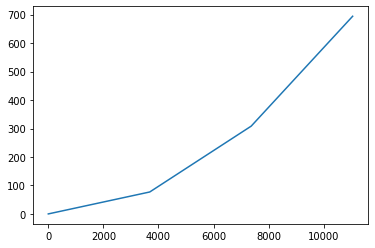

In [137]:
plt.plot(x0, z0)
plt.show()

In [138]:
# rng = np.random.default_rng(seed=29)
rng = np.random.default_rng(seed=30)
q0=np.zeros(12*node_N)

In [139]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)

In [140]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])

    
    
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]

#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
   
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
############################################################    
    ddx,ddy, ddz = np.linalg.solve(Ws*Re_b(Ret),Z).T 
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
#     tmp=phi(ddx_phi,ddy_phi, ddz_phi, Ret)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
############################################################    
#     ans_x=[]
#     ans_y=[]
#     ans_z=[]
#     RRRR=Re_b(Ret)
#     for i in range(len(RRRR)):
#         a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_y.append(b)
#         ans_z.append(c)
    
#     ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    
   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))


#############
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
    

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans
    

In [141]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [142]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [143]:
root

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [144]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [145]:
x0

[0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162]

In [146]:
x0_

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446])

In [147]:
z0

[0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863]

In [148]:
z0_

array([  0.        ,  77.06804645, 308.4070593 , 694.42189511])

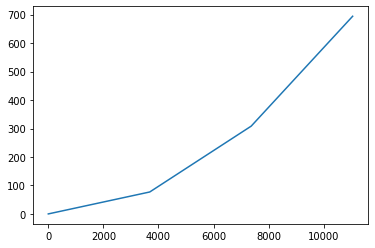

In [149]:
plt.plot(x0_, z0_)
plt.show()

In [150]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)

In [151]:
# q0[10*node_N]=q0[8*node_N]=0

In [152]:
q0

array([ 0.00000000e+00,  3.68422828e+03,  7.36845656e+03,  1.10526848e+04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  7.70680464e+01,  3.08407059e+02,  6.94421895e+02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.57464114e+00,  7.43283387e-01, -9.69888818e-01, -2.12004449e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.86729919e-01,  2.36241892e+00, -9.43225490e-01,  1.37579486e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

### Dynamics

In [158]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
#     print(t)
    
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
# #     x[-1]=x0[-1]+10*np.sin(t)
#     x[-1]=x0_[-1]+100*np.sin(t)
# #     y[-1]+=5*np.cos(t)
# #     z[-1]=z0[-1]+2.5*np.sin(t)
#     z[-1]=z0_[-1]+2.5*np.sin(t)

#     x[0]=0
#     y[0]=0
#     z[0]=0

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
#     dx[0]=0
#     dy[0]=0
#     dz[0]=0

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     print(φ[-1],θ[-1],ψ[-1])
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)

    # PD controller after 30 sec
#     if t<30:
#         ddη=np.linalg.lstsq(V.M, -left + tau(η, dη, wave_coef, Fx_0/η[0], 0, t), rcond=None)[0]
#     else:

    hack =1
    ddη=np.linalg.lstsq(V.M.astype(np.float32)*hack, left.astype(np.float32) 
                        - tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
                        , rcond=None)[0]
#     print(ddη)
#     print()
#     print('ddη', ddη)
 
    tau_force = V.tau(η,dη,ddη).astype(np.float32)
#     tau_force = tau(η,dη, wave_coef, kp, kd, t) # simple motion 
#     print(tau_force)
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]
#     Z0=tau_force[:3]
#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
#     print(x,z)
   
    Z1 =d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T
    
    Z= (Z1 + Z2 
        + Z0
       )

############################################################    
#     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
############################################################    
    ans_x=[]
    ans_y=[]
    ans_z=[]
    RRRR=Re_b(Ret)
    hack2=1e-1
    for i in range(len(RRRR)):
#         print(RRRR[i].shape)
        a,b,c=np.linalg.lstsq(Ws*RRRR[i] #+hack2*np.identity(3)
                              , Z[i], rcond=None)[0]
        ans_x.append(a)
        ans_y.append(b)
        ans_z.append(c)
    
    ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)
#     print(ddx,ddy, ddz)
    
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
#     print(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T))
#     print(np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
#                            np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))

#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None))
#     print(d_s(phi,x,y,z,Ret).T)
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None)))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)
#     print(np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)).shape)

#     C0=np.einsum('ijk,kp->ijp',
#                  np.linalg.inv(Π(φ,θ,ψ)), tau_force[3:].reshape(3,1)
#                 ) 
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     print(C1.shape,C2.shape,C3.shape,C4.shape,C5.shape)
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))

############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i] #+hack2*np.identity(3)
                              ,B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#     ddx[-1],ddy[-1],ddz[-1],ddφ[-1],ddθ[-1],ddψ[-1]=ddη
#     print(ddφ,ddθ,ddψ)

    ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     A1111=np.concatenate([dx, ddx, 
#                           np.zeros(node_N), np.zeros(node_N),
#                           dz, ddz,
#                           np.zeros(node_N),  np.zeros(node_N),
#                           np.zeros(node_N), np.zeros(node_N),
#                           np.zeros(node_N),  np.zeros(node_N),
#                           ], axis=0)

        

    print(A1111)
    return A1111

In [159]:
# ode15s = scipy.integrate.ode(grayscott1d)
# # ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [160]:
# us=ode15s.integrate(10)

In [161]:
tspan = (0., 5)
# tspan = (0., 10)

In [162]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
# us=ode15s.integrate(10)
print(datetime.now() - startTime1)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.12055088e+10 -1.80863800e+09 -1.45614874e+09
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.67206833e+09 -6.38394905e+08 -6.81936541e+08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.11197401e+09 -1.11120021e+09 -2.31634143e+08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -6.10310225e+13  7.09381010e+13 -2.00945990e+15
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  9.19509484e+13 -1.04069286e+14 -9.90046500e+15
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  4.43900666e+11  7.68273747e+13  4.32128276e+14]
[ 0.00000000e+00 -4.14180118e-11 -6.68512166e-12 -5.38224426e-12
  0.00000000e+00 -1.12055088e+10 -1.80863800e+09 -1.45614874e+09
  0.00000000e+00 -6.18033030e-12 -2.35964721e-12 -2.52058662e-12
  0.00000000e+00 -1.6720

[ 0.00000000e+00 -3.77317075e-06 -6.09004451e-07 -4.90312320e-07
  0.00000000e+00 -1.12054487e+10 -1.80857782e+09 -1.45608856e+09
  0.00000000e+00 -5.63029722e-07 -2.14965492e-07 -2.29627073e-07
  0.00000000e+00 -1.67207802e+09 -6.38404594e+08 -6.81946230e+08
  0.00000000e+00  7.11153535e-07 -3.74171503e-07 -7.79991551e-08
  0.00000000e+00  2.11196197e+09 -1.11121224e+09 -2.31646178e+08
  0.00000000e+00 -2.05505312e-02  2.38863038e-02 -6.76634361e-01
  0.00000000e+00 -6.10300006e+13  7.09359288e+13 -2.00944752e+15
  0.00000000e+00  3.09623288e-02 -3.50428956e-02 -3.33374001e+00
  0.00000000e+00  9.19515256e+13 -1.04069941e+14 -9.90046919e+15
  0.00000000e+00  1.49631367e-04  2.58702730e-02  1.45508174e-01
  0.00000000e+00  4.44843159e+11  7.68305506e+13  4.32125614e+14]
[ 0.00000000e+00 -4.14132878e-06 -6.68425681e-07 -5.38152418e-07
  0.00000000e+00 -1.12054428e+10 -1.80857195e+09 -1.45608269e+09
  0.00000000e+00 -6.17966325e-07 -2.35940468e-07 -2.52032621e-07
  0.00000000e+00 -1.6720

[ 0.00000000e+00 -4.12958807e-03 -6.56299435e-04 -5.26011710e-04
  0.00000000e+00 -1.11394361e+10 -1.74256521e+09 -1.39007596e+09
  0.00000000e+00 -6.19988037e-04 -2.37919771e-04 -2.54013710e-04
  0.00000000e+00 -1.68266842e+09 -6.48994996e+08 -6.92536632e+08
  0.00000000e+00  7.78189174e-04 -4.13166388e-04 -8.80595664e-05
  0.00000000e+00  2.09875945e+09 -1.12441476e+09 -2.44848694e+08
  0.00000000e+00 -2.23511538e+01  2.57796849e+01 -7.40229028e+02
  0.00000000e+00 -5.99094967e+13  6.85539857e+13 -1.99587452e+15
  0.00000000e+00  3.41043179e+01 -3.85994613e+01 -3.66027503e+03
  0.00000000e+00  9.25850219e+13 -1.04789455e+14 -9.90505150e+15
  0.00000000e+00  3.55208184e-01  2.90412573e+01  1.59183810e+02
  0.00000000e+00  1.47824254e+12  8.03132119e+13  4.29205676e+14]
[ 0.00000000e+00 -4.58692405e-03 -7.27714418e-04 -5.82950278e-04
  0.00000000e+00 -1.11320928e+10 -1.73522196e+09 -1.38273270e+09
  0.00000000e+00 -6.89118251e-04 -2.64597951e-04 -2.82480106e-04
  0.00000000e+00 -1.6838

[ 0.00000000e+00  1.31625422e+00  3.15228437e+00  3.22109034e+00
  0.00000000e+00  2.59215590e+10  3.53184507e+10  3.56699526e+10
  0.00000000e+00 -2.07319166e-01 -5.35463006e-03 -1.39299346e-02
  0.00000000e+00  3.37758731e+09  4.41121331e+09  4.36661261e+09
  0.00000000e+00 -2.88482290e-01 -9.18247069e-01 -7.46419078e-01
  0.00000000e+00 -5.31347026e+09 -8.53658851e+09 -7.65747930e+09
  0.00000000e+00  3.88142957e+04 -9.88558613e+04  3.52626584e+05
  0.00000000e+00  4.27652659e+14 -1.04627279e+15  6.01893513e+15
  0.00000000e+00  5.80651259e+04 -6.94643389e+04 -2.05675568e+06
  0.00000000e+00  5.52469086e+14 -6.85012162e+14 -1.05229608e+16
  0.00000000e+00  4.66827401e+04  1.79360885e+05 -7.60368034e+04
  0.00000000e+00  4.47931783e+14  1.70299272e+15 -1.29783510e+15]
[ 0.00000000e+00  1.80315013e+00  3.77778757e+00  3.85177395e+00
  0.00000000e+00  2.86819277e+10  3.80788255e+10  3.84301820e+10
  0.00000000e+00 -1.20511527e-01  9.66990225e-02  8.74608797e-02
  0.00000000e+00  4.9843

  0.00000000e+00 -2.27082370e+15 -6.27526271e+15  1.68699559e+15]
[ 0.00000000e+00  2.30069960e+01  3.43651851e+01  3.47958967e+01
  0.00000000e+00 -7.85930044e+10 -6.92008696e+10 -6.88238948e+10
  0.00000000e+00  9.51224369e+01  9.63704455e+01  9.63131143e+01
  0.00000000e+00  1.24566686e+11  1.25598688e+11  1.25555833e+11
  0.00000000e+00 -4.75788699e+00 -8.65214463e+00 -7.59324874e+00
  0.00000000e+00  1.55908616e+10  1.23698197e+10  1.32455257e+10
  0.00000000e+00 -7.77832653e+05  8.49059625e+05  8.81508663e+06
  0.00000000e+00 -2.69034825e+15  4.83801260e+15 -1.14339140e+16
  0.00000000e+00  1.43683117e+06 -2.16868030e+06  3.73334326e+06
  0.00000000e+00  5.38135913e+14 -1.21115351e+15  1.52219677e+16
  0.00000000e+00 -6.80031988e+05 -1.09554438e+06 -1.92001124e+06
  0.00000000e+00 -2.46206640e+15 -6.98458591e+15  2.46997665e+15]
[ 0.00000000e+00  3.07469772e+01  4.21053120e+01  4.25348973e+01
  0.00000000e+00 -8.12394935e+10 -7.18467290e+10 -7.14704799e+10
  0.00000000e+00  9.768

  0.00000000e+00  2.39725419e+15  8.38430325e+15 -6.68852732e+15]
[ 0.00000000e+00 -1.59340420e+01  6.27343040e+00  7.14421826e+00
  0.00000000e+00  1.91452075e+11  2.00814972e+11  2.01164495e+11
  0.00000000e+00  6.28676191e+01  6.53217027e+01  6.52143982e+01
  0.00000000e+00  1.55880993e+09  2.61175900e+09  2.54101669e+09
  0.00000000e+00  2.89684342e+00 -4.73962863e+00 -2.65345153e+00
  0.00000000e+00 -3.83939925e+10 -4.16418539e+10 -4.07506989e+10
  0.00000000e+00 -8.42492905e+05  1.14760915e+06  2.25269559e+05
  0.00000000e+00  2.94197398e+15 -6.64034995e+15  4.05259913e+16
  0.00000000e+00  9.60742369e+05 -1.42618145e+06 -1.12235545e+07
  0.00000000e+00  2.37671739e+15 -2.88438462e+15 -1.71415388e+16
  0.00000000e+00 -6.62038691e+05 -1.28658746e+06 -3.83140520e+04
  0.00000000e+00  2.76847037e+15  9.92505952e+15 -8.74918173e+15]
[ 0.00000000e+00 -4.25576777e+01 -2.03502374e+01 -1.94753120e+01
  0.00000000e+00  2.00971814e+11  2.10332417e+11  2.10683935e+11
  0.00000000e+00  5.267

[ 0.00000000e+00  4.56158682e+01  7.09588255e+01  7.19466785e+01
  0.00000000e+00  2.78975568e+11  2.88332599e+11  2.88660464e+11
  0.00000000e+00  6.71733270e+01  6.99809408e+01  6.98488200e+01
  0.00000000e+00  1.91053841e+11  1.92109685e+11  1.92013359e+11
  0.00000000e+00 -9.44678829e+00 -1.81723933e+01 -1.57872785e+01
  0.00000000e+00 -5.58944456e+10 -5.91462089e+10 -5.82612221e+10
  0.00000000e+00  5.73755920e+04 -9.23030330e+05  1.34558237e+07
  0.00000000e+00  1.82311629e+15 -5.74541035e+15  6.56037524e+16
  0.00000000e+00  1.76564691e+06 -2.42530778e+06 -1.60716175e+07
  0.00000000e+00  5.16798810e+15 -7.18492636e+15  1.22034333e+16
  0.00000000e+00  1.84825892e+05  1.81048182e+06 -2.95882488e+06
  0.00000000e+00  1.66884708e+15  8.46381488e+15 -1.44352723e+16]
[ 0.00000000e+00  7.16778461e+01  9.80388711e+01  9.90627027e+01
  0.00000000e+00  2.32938912e+11  2.42294734e+11  2.42624577e+11
  0.00000000e+00  9.40487814e+01  9.69711837e+01  9.68283807e+01
  0.00000000e+00  2.8331

[ 0.00000000e+00 -1.48531791e+02 -1.13322910e+02 -1.11928835e+02
  0.00000000e+00 -4.46877272e+11 -4.37575539e+11 -4.37147131e+11
  0.00000000e+00  3.13959183e+02  3.17885620e+02  3.17675727e+02
  0.00000000e+00 -2.20542041e+11 -2.19461112e+11 -2.19506095e+11
  0.00000000e+00  2.92887161e+01  1.71224724e+01  2.04498690e+01
  0.00000000e+00  8.93134347e+10  8.60298149e+10  8.69557636e+10
  0.00000000e+00 -5.98918618e+06  1.04682709e+07 -1.52940908e+07
  0.00000000e+00 -3.87528398e+15  1.06098891e+16 -9.66537162e+16
  0.00000000e+00  2.22102793e+06 -4.19082751e+06  2.41437680e+07
  0.00000000e+00 -6.89294482e+15  9.46730221e+15 -2.55877608e+16
  0.00000000e+00 -5.44791072e+06 -1.50617268e+07  3.00430377e+06
  0.00000000e+00 -3.45959035e+15 -1.53713117e+16  2.02314618e+16]
[ 0.00000000e+00 -1.49734449e+02 -1.14524058e+02 -1.13131337e+02
  0.00000000e+00 -5.78493246e+11 -5.69190473e+11 -5.68745310e+11
  0.00000000e+00  3.60725630e+02  3.64650722e+02  3.64438360e+02
  0.00000000e+00 -2.0132

  0.00000000e+00  1.45332652e+16  4.99091184e+16 -3.11965871e+16]
[ 0.00000000e+00 -1.66431588e+02 -1.24448935e+02 -1.22778478e+02
  0.00000000e+00  8.19159129e+11  8.28409079e+11  8.28665984e+11
  0.00000000e+00 -6.16241080e+01 -5.68873356e+01 -5.71580800e+01
  0.00000000e+00 -4.42464348e+11 -4.41328330e+11 -4.41499810e+11
  0.00000000e+00  3.28418953e+01  1.82532979e+01  2.22731444e+01
  0.00000000e+00 -1.63846785e+11 -1.67193951e+11 -1.66241871e+11
  0.00000000e+00 -1.31425187e+06  2.94600096e+06 -3.07954700e+07
  0.00000000e+00  1.84678513e+16 -3.89086299e+16  1.57691779e+17
  0.00000000e+00 -1.53822743e+06  2.61750058e+06 -4.59860797e+07
  0.00000000e+00  4.94797136e+15 -3.10860175e+15 -1.23150833e+17
  0.00000000e+00 -9.22600303e+05 -3.39111350e+06  6.29703061e+06
  0.00000000e+00  1.73531107e+16  5.84061460e+16 -3.28123579e+16]
[ 0.00000000e+00 -1.13457780e+02 -7.08769459e+01 -6.91898749e+01
  0.00000000e+00  9.62920972e+11  9.72170563e+11  9.72399510e+11
  0.00000000e+00 -9.023

[ 0.00000000e+00  3.09294859e+02  3.55757683e+02  3.57521357e+02
  0.00000000e+00  7.67324183e+11  7.76585122e+11  7.76768181e+11
  0.00000000e+00  9.44454916e+01  9.97283231e+01  9.93407519e+01
  0.00000000e+00  1.07849621e+12  1.07960975e+12  1.07932522e+12
  0.00000000e+00 -6.23129535e+01 -7.85182544e+01 -7.40543405e+01
  0.00000000e+00 -1.53493261e+11 -1.56818142e+11 -1.55935358e+11
  0.00000000e+00  4.05341014e+06 -1.09982088e+07  7.53901642e+07
  0.00000000e+00 -2.02894580e+15 -5.27451628e+15  1.98805200e+17
  0.00000000e+00  5.42269859e+06 -6.66454494e+06 -4.31160907e+07
  0.00000000e+00  1.94607753e+16 -2.97403541e+16  1.44635871e+17
  0.00000000e+00  4.00967547e+06  1.72462024e+07 -1.74733224e+07
  0.00000000e+00 -2.30412769e+15  6.88283788e+15 -4.71520313e+16]
[ 0.00000000e+00  2.93417503e+02  3.40102215e+02  3.41874401e+02
  0.00000000e+00  6.30715248e+11  6.39974479e+11  6.40178648e+11
  0.00000000e+00  1.36551543e+02  1.41860004e+02  1.41466723e+02
  0.00000000e+00  1.0425

  0.00000000e+00 -1.16903197e+16 -6.94487576e+16  6.70176633e+16]
[ 0.00000000e+00 -8.38242571e+02 -7.81581644e+02 -7.79365601e+02
  0.00000000e+00 -1.54901556e+12 -1.53995997e+12 -1.53947988e+12
  0.00000000e+00  6.34062476e+02  6.40595974e+02  6.40101787e+02
  0.00000000e+00 -1.50634804e+12 -1.50510985e+12 -1.50516131e+12
  0.00000000e+00  1.67203813e+02  1.47283900e+02  1.52796587e+02
  0.00000000e+00  3.09906577e+11  3.06446997e+11  3.07530219e+11
  0.00000000e+00 -2.09683620e+07  4.28455123e+07 -1.05298326e+08
  0.00000000e+00 -5.09727818e+15  2.89366987e+16 -3.25389279e+17
  0.00000000e+00 -1.92661123e+06 -7.21770378e+05  8.52211938e+07
  0.00000000e+00 -3.30006879e+16  5.16354690e+16 -1.53289042e+17
  0.00000000e+00 -1.96385189e+07 -6.47835585e+07  1.53909303e+07
  0.00000000e+00 -4.16327972e+15 -4.27772726e+16  5.56651535e+16]
[ 0.00000000e+00 -9.57734504e+02 -9.00641622e+02 -8.98397830e+02
  0.00000000e+00 -1.42011849e+12 -1.41108603e+12 -1.41061144e+12
  0.00000000e+00  5.549

  0.00000000e+00  1.31249173e+16  6.68181121e+15  4.91469584e+16]
[ 0.00000000e+00 -1.22586642e+03 -1.16619443e+03 -1.16381379e+03
  0.00000000e+00  3.28275848e+11  3.37208416e+11  3.37567728e+11
  0.00000000e+00 -1.83024489e+01 -1.13431109e+01 -1.18565165e+01
  0.00000000e+00 -2.83634486e+12 -2.83496904e+12 -2.83521733e+12
  0.00000000e+00  2.44769537e+02  2.23685374e+02  2.29568524e+02
  0.00000000e+00 -6.54705325e+10 -6.90463329e+10 -6.78738973e+10
  0.00000000e+00 -1.85144197e+07  4.31076070e+07 -1.98265797e+08
  0.00000000e+00  4.26363587e+16 -7.60423690e+16 -3.01017884e+16
  0.00000000e+00 -1.34341233e+07  2.05018717e+07 -1.87662527e+07
  0.00000000e+00 -2.74268472e+16  6.50517687e+16 -5.24997922e+17
  0.00000000e+00 -1.70477999e+07 -6.44812178e+07  3.25098410e+07
  0.00000000e+00  4.12350289e+16  1.18434854e+17  4.79179600e+15]
[ 0.00000000e+00 -1.05346454e+03 -9.93509370e+02 -9.91123645e+02
  0.00000000e+00  8.95015851e+11  9.03957265e+11  9.04244569e+11
  0.00000000e+00 -1.363

[ 0.00000000e+00  8.18546655e+02  8.84457807e+02  8.86752148e+02
  0.00000000e+00  2.26384546e+12  2.27283330e+12  2.27254983e+12
  0.00000000e+00 -1.99648139e+02 -1.91713870e+02 -1.92628478e+02
  0.00000000e+00  3.09708758e+12  3.09838983e+12  3.09755622e+12
  0.00000000e+00 -1.63980587e+02 -1.87583064e+02 -1.80950205e+02
  0.00000000e+00 -4.52623756e+11 -4.56170471e+11 -4.55263141e+11
  0.00000000e+00  1.76436064e+07 -4.94708272e+07  2.15836671e+08
  0.00000000e+00 -2.89181466e+15 -2.87320734e+16  5.10362762e+17
  0.00000000e+00  7.57195078e+06 -1.35265117e+06 -1.25998087e+08
  0.00000000e+00  5.91401058e+16 -1.00356311e+17  3.53092852e+17
  0.00000000e+00  1.64924281e+07  7.35015934e+07 -6.47147722e+07
  0.00000000e+00 -4.73309915e+15  3.76405444e+16 -1.37432312e+17]
[ 0.00000000e+00  9.44414400e+02  1.01031563e+03  1.01261127e+03
  0.00000000e+00  3.68130389e+12  3.69029168e+12  3.68980885e+12
  0.00000000e+00 -4.87768083e+02 -4.79820980e+02 -4.80717531e+02
  0.00000000e+00  3.5585

  0.00000000e+00 -1.71925278e+17 -6.90709131e+17  2.87698589e+16]
[ 0.00000000e+00 -2.61584066e+03 -2.53989669e+03 -2.53779368e+03
  0.00000000e+00 -7.59712659e+12 -7.58908377e+12 -7.59051320e+12
  0.00000000e+00  4.79616878e+03  4.80539051e+03  4.80487277e+03
  0.00000000e+00  2.84377240e+12  2.84510135e+12  2.84622193e+12
  0.00000000e+00  5.23088462e+02  4.95475709e+02  5.03399744e+02
  0.00000000e+00  1.51985027e+12  1.51604608e+12  1.51794084e+12
  0.00000000e+00 -1.06478695e+08  1.94866378e+08  1.98048239e+08
  0.00000000e+00 -1.80207177e+17  4.68768160e+17 -1.91424926e+17
  0.00000000e+00  2.35999835e+07 -5.53619849e+07  4.20333936e+08
  0.00000000e+00 -4.83091699e+16  4.55943740e+15  2.76344289e+17
  0.00000000e+00 -1.05398064e+08 -3.12468066e+08 -6.36517956e+07
  0.00000000e+00 -1.78476303e+17 -7.64215387e+17  2.13950419e+16]
[ 0.00000000e+00 -4.77148103e+03 -4.69355015e+03 -4.69198276e+03
  0.00000000e+00 -8.84169653e+12 -8.83477836e+12 -8.83714914e+12
  0.00000000e+00  5.517

  0.00000000e+00 -2.39954784e+17 -2.04614323e+18  5.45389107e+15]
[ 0.00000000e+00 -5.61069180e+03 -5.53216412e+03 -5.53079197e+03
  0.00000000e+00 -9.46985889e+12 -9.46350729e+12 -9.46599785e+12
  0.00000000e+00  5.68505396e+03  5.69488542e+03  5.69450794e+03
  0.00000000e+00  2.26837923e+12  2.27044379e+12  2.27007733e+12
  0.00000000e+00  1.12226793e+03  1.09323179e+03  1.10196470e+03
  0.00000000e+00  1.89471954e+12  1.89047883e+12  1.89318162e+12
  0.00000000e+00 -1.79846694e+08  4.54157645e+08  1.57685839e+08
  0.00000000e+00 -2.43596802e+17  1.25842097e+18 -5.26365344e+16
  0.00000000e+00  2.94650845e+06 -7.53947448e+07  5.24145877e+08
  0.00000000e+00 -6.85887033e+16 -1.77440351e+17  3.42540666e+17
  0.00000000e+00 -1.78513549e+08 -7.51487497e+08 -6.03494506e+07
  0.00000000e+00 -2.43971551e+17 -2.19745146e+18  5.70019120e+15]
[ 0.00000000e+00 -5.60850855e+03 -5.52997692e+03 -5.52860606e+03
  0.00000000e+00 -9.47111487e+12 -9.46475310e+12 -9.46724995e+12
  0.00000000e+00  5.682

  0.00000000e+00 -2.78701901e+17 -4.51563346e+18  9.77520972e+15]
[ 0.00000000e+00 -6.76376036e+03 -6.68454112e+03 -6.68346127e+03
  0.00000000e+00 -1.02615913e+13 -1.02562471e+13 -1.02586817e+13
  0.00000000e+00  5.94373279e+03  5.95380109e+03  5.95336600e+03
  0.00000000e+00  2.20447641e+12  2.20643868e+12  2.20580224e+12
  0.00000000e+00  1.35297397e+03  1.32343731e+03  1.33250089e+03
  0.00000000e+00  2.05316429e+12  2.04885447e+12  2.05180311e+12
  0.00000000e+00 -2.10295145e+08  6.62894068e+08  1.53216515e+08
  0.00000000e+00 -2.80157160e+17  2.65372011e+18 -1.71540641e+16
  0.00000000e+00 -5.47964082e+06 -8.40810691e+07  5.68031849e+08
  0.00000000e+00 -7.43636623e+16  3.49092173e+18  4.10618710e+17
  0.00000000e+00 -2.09050214e+08 -1.12222816e+09 -5.94738151e+07
  0.00000000e+00 -2.81082855e+17 -4.77955195e+18  1.01401367e+16]
[ 0.00000000e+00 -6.76332742e+03 -6.68410738e+03 -6.68302806e+03
  0.00000000e+00 -1.02613327e+13 -1.02559838e+13 -1.02584227e+13
  0.00000000e+00  5.943

[ 0.00000000e+00 -7.03623170e+03 -6.95687443e+03 -6.95585855e+03
  0.00000000e+00 -1.04612446e+13 -1.04561867e+13 -1.04585466e+13
  0.00000000e+00  6.00154205e+03  6.01166096e+03  6.01120919e+03
  0.00000000e+00  2.19904599e+12  2.20092598e+12  2.20028707e+12
  0.00000000e+00  1.40749011e+03  1.37784000e+03  1.38698177e+03
  0.00000000e+00  2.09311578e+12  2.08879446e+12  2.09179923e+12
  0.00000000e+00 -2.17784990e+08  7.38807592e+08  1.52842796e+08
  0.00000000e+00 -2.90145637e+17  1.03929688e+19 -1.00848007e+16
  0.00000000e+00 -7.45541887e+06 -1.07495656e+10  5.79098363e+08
  0.00000000e+00 -7.56042429e+16  8.72827557e+20  4.31125602e+17
  0.00000000e+00 -2.16566672e+08 -1.25896736e+09 -5.91888163e+07
  0.00000000e+00 -2.91153955e+17 -1.94657046e+19  1.17398700e+16]
[ 0.00000000e+00 -7.07070248e+03 -6.99132858e+03 -6.99032049e+03
  0.00000000e+00 -1.04869249e+13 -1.04825308e+13 -1.04842533e+13
  0.00000000e+00  6.00877798e+03  6.01890305e+03  6.01844918e+03
  0.00000000e+00  2.1985

[ 0.00000000e+00 -6.98686619e+03 -6.90753292e+03 -6.90650583e+03
  0.00000000e+00 -1.04246328e+13 -1.04195140e+13 -1.04218969e+13
  0.00000000e+00  5.99113856e+03  6.00124868e+03  6.00079983e+03
  0.00000000e+00  2.19976301e+12  2.20165872e+12  2.20101926e+12
  0.00000000e+00  1.39761299e+03  1.36798323e+03  1.37711089e+03
  0.00000000e+00  2.08578963e+12  2.08147254e+12  2.08446492e+12
  0.00000000e+00 -2.16416365e+08  7.23646438e+08  1.52891657e+08
  0.00000000e+00 -2.88292036e+17  2.84041722e+18 -1.13253933e+16
  0.00000000e+00 -7.09911534e+06  5.58537414e+08  5.77069004e+08
  0.00000000e+00 -7.53827501e+16  1.89436105e+20  4.27262601e+17
  0.00000000e+00 -2.15193529e+08 -1.23157012e+09 -5.92439301e+07
  0.00000000e+00 -2.89287173e+17 -5.06680348e+18  1.14374892e+16]
[ 0.00000000e+00 -7.01035692e+03 -6.93101210e+03 -6.92999038e+03
  0.00000000e+00 -1.04419991e+13 -1.04369123e+13 -1.04392813e+13
  0.00000000e+00  5.99609548e+03  6.00620987e+03  6.00575957e+03
  0.00000000e+00  2.1993

[ 0.00000000e+00 -7.02876365e+03 -6.94940998e+03 -6.94839236e+03
  0.00000000e+00 -1.04556848e+13 -1.04506889e+13 -1.04529811e+13
  0.00000000e+00  5.99996517e+03  6.01008289e+03  6.00963145e+03
  0.00000000e+00  2.19912851e+12  2.20103986e+12  2.20037187e+12
  0.00000000e+00  1.40599595e+03  1.37634883e+03  1.38548855e+03
  0.00000000e+00  2.09200335e+12  2.08765306e+12  2.09068556e+12
  0.00000000e+00 -2.17576459e+08  7.30088646e+08  1.52848325e+08
  0.00000000e+00 -2.89863128e+17 -3.85248668e+18 -1.02710618e+16
  0.00000000e+00 -7.40201288e+06  1.88736691e+10  5.78790205e+08
  0.00000000e+00 -7.55711190e+16 -2.98258392e+22  4.30535457e+17
  0.00000000e+00 -2.16357640e+08 -1.24226227e+09 -5.91975176e+07
  0.00000000e+00 -2.90869614e+17  8.13745012e+18  1.16937644e+16]
[ 0.00000000e+00 -7.02876364e+03 -6.94940998e+03 -6.94839236e+03
  0.00000000e+00 -1.04556848e+13 -1.04506783e+13 -1.04529811e+13
  0.00000000e+00  5.99996516e+03  6.01008289e+03  6.00963144e+03
  0.00000000e+00  2.1991

[ 0.00000000e+00 -7.03016069e+03 -6.95080636e+03 -6.94978904e+03
  0.00000000e+00 -1.04567275e+13 -1.04517398e+13 -1.04540248e+13
  0.00000000e+00  6.00025899e+03  6.01037696e+03  6.00992543e+03
  0.00000000e+00  2.19910644e+12  2.20101989e+12  2.20034938e+12
  0.00000000e+00  1.40627548e+03  1.37662777e+03  1.38576790e+03
  0.00000000e+00  2.09221098e+12  2.08785797e+12  2.09089343e+12
  0.00000000e+00 -2.17615191e+08  7.30864919e+08  1.52846956e+08
  0.00000000e+00 -2.89915741e+17  6.24435317e+18 -1.02359420e+16
  0.00000000e+00 -7.41211017e+06 -8.03174505e+09  5.78847736e+08
  0.00000000e+00 -7.55774004e+16 -2.07741256e+23  4.30645314e+17
  0.00000000e+00 -2.16396507e+08 -1.24361355e+09 -5.91959544e+07
  0.00000000e+00 -2.90922565e+17 -1.15141580e+19  1.17024078e+16]
[ 0.00000000e+00 -7.03504790e+03 -6.95569125e+03 -6.95467499e+03
  0.00000000e+00 -1.04603535e+13 -1.04549077e+13 -1.04576545e+13
  0.00000000e+00  6.00128659e+03  6.01140547e+03  6.01095362e+03
  0.00000000e+00  2.1990

[ 0.00000000e+00 -7.03012844e+03 -6.95077413e+03 -6.94975680e+03
  0.00000000e+00 -1.04566979e+13 -1.04516983e+13 -1.04539952e+13
  0.00000000e+00  6.00025220e+03  6.01037018e+03  6.00991865e+03
  0.00000000e+00  2.19910701e+12  2.20101588e+12  2.20034996e+12
  0.00000000e+00  1.40626903e+03  1.37662134e+03  1.38576145e+03
  0.00000000e+00  2.09220614e+12  2.08785786e+12  2.09088858e+12
  0.00000000e+00 -2.17614297e+08  7.31556035e+08  1.52846988e+08
  0.00000000e+00 -2.89914522e+17  4.63464314e+18 -1.02369099e+16
  0.00000000e+00 -7.41187711e+06 -3.13717184e+09  5.78846408e+08
  0.00000000e+00 -7.55772574e+16 -1.58107213e+23  4.30642746e+17
  0.00000000e+00 -2.16395610e+08 -1.24495158e+09 -5.91959905e+07
  0.00000000e+00 -2.90921385e+17 -8.37249522e+18  1.17021762e+16]
[ 0.00000000e+00 -7.03045061e+03 -6.95109615e+03 -6.95007889e+03
  0.00000000e+00 -1.04569349e+13 -1.04519299e+13 -1.04542324e+13
  0.00000000e+00  6.00031996e+03  6.01043799e+03  6.00998644e+03
  0.00000000e+00  2.1991

[ 0.00000000e+00 -7.02845444e+03 -6.94910093e+03 -6.94808324e+03
  0.00000000e+00 -1.04554524e+13 -1.04504479e+13 -1.04527484e+13
  0.00000000e+00  5.99990013e+03  6.01001780e+03  6.00956637e+03
  0.00000000e+00  2.19913235e+12  2.20104065e+12  2.20037581e+12
  0.00000000e+00  1.40593409e+03  1.37628709e+03  1.38542672e+03
  0.00000000e+00  2.09195732e+12  2.08761031e+12  2.09063948e+12
  0.00000000e+00 -2.17567887e+08  7.31133965e+08  1.52848630e+08
  0.00000000e+00 -2.89851475e+17 -8.69703211e+17 -1.02786729e+16
  0.00000000e+00 -7.39977792e+06  1.02574249e+10  5.78777473e+08
  0.00000000e+00 -7.55697422e+16 -3.14713433e+22  4.30511090e+17
  0.00000000e+00 -2.16349039e+08 -1.24424011e+09 -5.91978632e+07
  0.00000000e+00 -2.90857894e+17  2.28377865e+18  1.16918821e+16]
[ 0.00000000e+00 -7.02852897e+03 -6.94917542e+03 -6.94815775e+03
  0.00000000e+00 -1.04555082e+13 -1.04505043e+13 -1.04528043e+13
  0.00000000e+00  5.99991580e+03  6.01003348e+03  6.00958206e+03
  0.00000000e+00  2.1991

[ 0.00000000e+00 -7.02966623e+03 -6.95031214e+03 -6.94929472e+03
  0.00000000e+00 -1.04563515e+13 -1.04513520e+13 -1.04536484e+13
  0.00000000e+00  6.00015500e+03  6.01027289e+03  6.00982139e+03
  0.00000000e+00  2.19911470e+12  2.20102399e+12  2.20035779e+12
  0.00000000e+00  1.40617655e+03  1.37652905e+03  1.38566903e+03
  0.00000000e+00  2.09213745e+12  2.08778892e+12  2.09081981e+12
  0.00000000e+00 -2.17601482e+08  7.31308017e+08  1.52847441e+08
  0.00000000e+00 -2.89897106e+17  9.69376066e+18 -1.02484566e+16
  0.00000000e+00 -7.40853641e+06 -1.58286042e+10  5.78827373e+08
  0.00000000e+00 -7.55751964e+16 -2.66539059e+25  4.30606470e+17
  0.00000000e+00 -2.16382750e+08 -1.24450655e+09 -5.91965077e+07
  0.00000000e+00 -2.90903823e+17 -1.81878727e+19  1.16993313e+16]
[ 0.00000000e+00 -7.02969663e+03 -6.95034252e+03 -6.94932511e+03
  0.00000000e+00 -1.04563731e+13 -1.04513732e+13 -1.04536701e+13
  0.00000000e+00  6.00016139e+03  6.01027928e+03  6.00982778e+03
  0.00000000e+00  2.1991

[ 0.00000000e+00 -7.02953484e+03 -6.95018081e+03 -6.94916336e+03
  0.00000000e+00 -1.04562569e+13 -1.04512582e+13 -1.04535537e+13
  0.00000000e+00  6.00012736e+03  6.01024523e+03  6.00979374e+03
  0.00000000e+00  2.19911683e+12  2.20102652e+12  2.20035996e+12
  0.00000000e+00  1.40615026e+03  1.37650281e+03  1.38564275e+03
  0.00000000e+00  2.09211792e+12  2.08776904e+12  2.09080026e+12
  0.00000000e+00 -2.17597839e+08  7.31216577e+08  1.52847569e+08
  0.00000000e+00 -2.89892172e+17  4.78559953e+18 -1.02517928e+16
  0.00000000e+00 -7.40758675e+06 -3.57042493e+09  5.78821962e+08
  0.00000000e+00 -7.55746158e+16 -6.50941051e+23  4.30596112e+17
  0.00000000e+00 -2.16379095e+08 -1.24433688e+09 -5.91966547e+07
  0.00000000e+00 -2.90898869e+17 -8.66521325e+18  1.16985132e+16]
[ 0.00000000e+00 -7.02954230e+03 -6.95018826e+03 -6.94917081e+03
  0.00000000e+00 -1.04562637e+13 -1.04512650e+13 -1.04535606e+13
  0.00000000e+00  6.00012893e+03  6.01024680e+03  6.00979530e+03
  0.00000000e+00  2.1991

[ 0.00000000e+00 -7.02964875e+03 -6.95029466e+03 -6.94927724e+03
  0.00000000e+00 -1.04563412e+13 -1.04513418e+13 -1.04536381e+13
  0.00000000e+00  6.00015132e+03  6.01026921e+03  6.00981771e+03
  0.00000000e+00  2.19911555e+12  2.20102488e+12  2.20035865e+12
  0.00000000e+00  1.40617305e+03  1.37652556e+03  1.38566553e+03
  0.00000000e+00  2.09213488e+12  2.08778633e+12  2.09081724e+12
  0.00000000e+00 -2.17600998e+08  7.31299125e+08  1.52847458e+08
  0.00000000e+00 -2.89896449e+17  1.33877543e+19 -1.02487988e+16
  0.00000000e+00 -7.40841005e+06 -2.50939224e+10  5.78826653e+08
  0.00000000e+00 -7.55750999e+16 -1.02702521e+25  4.30605045e+17
  0.00000000e+00 -2.16382264e+08 -1.24449030e+09 -5.91965273e+07
  0.00000000e+00 -2.90903166e+17 -2.53553199e+19  1.16992422e+16]
[ 0.00000000e+00 -7.02964875e+03 -6.95029466e+03 -6.94927724e+03
  0.00000000e+00 -1.04563412e+13 -1.04513418e+13 -1.04536381e+13
  0.00000000e+00  6.00015132e+03  6.01026921e+03  6.00981771e+03
  0.00000000e+00  2.1991

[ 0.00000000e+00 -7.02965089e+03 -6.95029680e+03 -6.94927938e+03
  0.00000000e+00 -1.04563435e+13 -1.04513441e+13 -1.04536404e+13
  0.00000000e+00  6.00015177e+03  6.01026966e+03  6.00981816e+03
  0.00000000e+00  2.19911555e+12  2.20102487e+12  2.20035865e+12
  0.00000000e+00  1.40617347e+03  1.37652598e+03  1.38566596e+03
  0.00000000e+00  2.09213517e+12  2.08778662e+12  2.09081753e+12
  0.00000000e+00 -2.17601057e+08  7.31301014e+08  1.52847456e+08
  0.00000000e+00 -2.89896541e+17  1.47816406e+19 -1.02488128e+16
  0.00000000e+00 -7.40842550e+06 -2.85803078e+10  5.78826741e+08
  0.00000000e+00 -7.55751151e+16 -1.17973018e+25  4.30605206e+17
  0.00000000e+00 -2.16382323e+08 -1.24449384e+09 -5.91965249e+07
  0.00000000e+00 -2.90903258e+17 -2.80594991e+19  1.16992418e+16]
[ 0.00000000e+00 -7.02965196e+03 -6.95029787e+03 -6.94928044e+03
  0.00000000e+00 -1.04563446e+13 -1.04513452e+13 -1.04536416e+13
  0.00000000e+00  6.00015199e+03  6.01026988e+03  6.00981838e+03
  0.00000000e+00  2.1991

  0.00000000e+00 -2.90903650e+17 -5.27888369e+19  1.16993345e+16]
[ 0.00000000e+00 -7.02966150e+03 -6.95030741e+03 -6.94928999e+03
  0.00000000e+00 -1.04563537e+13 -1.04513541e+13 -1.04536507e+13
  0.00000000e+00  6.00015400e+03  6.01027189e+03  6.00982039e+03
  0.00000000e+00  2.19911470e+12  2.20102390e+12  2.20035779e+12
  0.00000000e+00  1.40617560e+03  1.37652810e+03  1.38566808e+03
  0.00000000e+00  2.09213674e+12  2.08778831e+12  2.09081910e+12
  0.00000000e+00 -2.17601351e+08  7.31320450e+08  1.52847445e+08
  0.00000000e+00 -2.89896901e+17  2.76521848e+19 -1.02483967e+16
  0.00000000e+00 -7.40850223e+06 -6.06544095e+10  5.78827178e+08
  0.00000000e+00 -7.55751703e+16 -1.00423690e+26  4.30606049e+17
  0.00000000e+00 -2.16382619e+08 -1.24453092e+09 -5.91965130e+07
  0.00000000e+00 -2.90903650e+17 -5.30235644e+19  1.16993345e+16]
[ 0.00000000e+00 -7.02966191e+03 -6.95030782e+03 -6.94929040e+03
  0.00000000e+00 -1.04563537e+13 -1.04513540e+13 -1.04536507e+13
  0.00000000e+00  6.000

[ 0.00000000e+00 -7.02966497e+03 -6.95031088e+03 -6.94929346e+03
  0.00000000e+00 -1.04563572e+13 -1.04513572e+13 -1.04536541e+13
  0.00000000e+00  6.00015473e+03  6.01027262e+03  6.00982112e+03
  0.00000000e+00  2.19911470e+12  2.20102380e+12  2.20035779e+12
  0.00000000e+00  1.40617629e+03  1.37652880e+03  1.38566877e+03
  0.00000000e+00  2.09213731e+12  2.08778898e+12  2.09081967e+12
  0.00000000e+00 -2.17601447e+08  7.31336053e+08  1.52847442e+08
  0.00000000e+00 -2.89897065e+17  8.43430402e+20 -1.02484346e+16
  0.00000000e+00 -7.40852731e+06 -2.09339795e+12  5.78827321e+08
  0.00000000e+00 -7.55751756e+16 -4.71535668e+26  4.30606365e+17
  0.00000000e+00 -2.16382715e+08 -1.24456098e+09 -5.91965091e+07
  0.00000000e+00 -2.90903781e+17 -1.63528658e+21  1.16993316e+16]
[ 0.00000000e+00 -7.02966518e+03 -6.95031108e+03 -6.94929366e+03
  0.00000000e+00 -1.04563572e+13 -1.04513574e+13 -1.04536541e+13
  0.00000000e+00  6.00015477e+03  6.01027266e+03  6.00982116e+03
  0.00000000e+00  2.1991

[ 0.00000000e+00 -7.02966369e+03 -6.95030960e+03 -6.94929218e+03
  0.00000000e+00 -1.04563492e+13 -1.04513494e+13 -1.04536461e+13
  0.00000000e+00  6.00015446e+03  6.01027235e+03  6.00982085e+03
  0.00000000e+00  2.19911470e+12  2.20102385e+12  2.20035779e+12
  0.00000000e+00  1.40617604e+03  1.37652854e+03  1.38566852e+03
  0.00000000e+00  2.09213716e+12  2.08778878e+12  2.09081952e+12
  0.00000000e+00 -2.17601412e+08  7.31327867e+08  1.52847443e+08
  0.00000000e+00 -2.89897023e+17  5.28606983e+19 -1.02484651e+16
  0.00000000e+00 -7.40851805e+06 -1.23486953e+11  5.78827268e+08
  0.00000000e+00 -7.55751741e+16 -1.12906201e+27  4.30606210e+17
  0.00000000e+00 -2.16382680e+08 -1.24454518e+09 -5.91965106e+07
  0.00000000e+00 -2.90903740e+17 -1.01918392e+20  1.16993274e+16]
[ 0.00000000e+00 -7.02966376e+03 -6.95030967e+03 -6.94929225e+03
  0.00000000e+00 -1.04563492e+13 -1.04513494e+13 -1.04536461e+13
  0.00000000e+00  6.00015448e+03  6.01027237e+03  6.00982087e+03
  0.00000000e+00  2.1991

  0.00000000e+00 -2.90903759e+17 -1.75104016e+20  1.16993240e+16]
[ 0.00000000e+00 -7.02966413e+03 -6.95031004e+03 -6.94929262e+03
  0.00000000e+00 -1.04563560e+13 -1.04513562e+13 -1.04536530e+13
  0.00000000e+00  6.00015456e+03  6.01027244e+03  6.00982094e+03
  0.00000000e+00  2.19911470e+12  2.20102383e+12  2.20035779e+12
  0.00000000e+00  1.40617613e+03  1.37652863e+03  1.38566861e+03
  0.00000000e+00  2.09213716e+12  2.08778881e+12  2.09081952e+12
  0.00000000e+00 -2.17601424e+08  7.31331224e+08  1.52847443e+08
  0.00000000e+00 -2.89897042e+17  1.68783872e+20 -1.02484824e+16
  0.00000000e+00 -7.40852124e+06 -4.12521071e+11  5.78827286e+08
  0.00000000e+00 -7.55751850e+16 -1.19737927e+30  4.30606310e+17
  0.00000000e+00 -2.16382692e+08 -1.24455166e+09 -5.91965101e+07
  0.00000000e+00 -2.90903759e+17 -3.26768241e+20  1.16993236e+16]
[ 0.00000000e+00 -7.02966415e+03 -6.95031006e+03 -6.94929264e+03
  0.00000000e+00 -1.04563560e+13 -1.04513562e+13 -1.04536530e+13
  0.00000000e+00  6.000

[ 0.00000000e+00 -7.02966414e+03 -6.95031005e+03 -6.94929262e+03
  0.00000000e+00 -1.04563560e+13 -1.04513562e+13 -1.04536530e+13
  0.00000000e+00  6.00015456e+03  6.01027244e+03  6.00982094e+03
  0.00000000e+00  2.19911470e+12  2.20102383e+12  2.20035779e+12
  0.00000000e+00  1.40617613e+03  1.37652863e+03  1.38566861e+03
  0.00000000e+00  2.09213716e+12  2.08778881e+12  2.09081952e+12
  0.00000000e+00 -2.17601424e+08  7.31331596e+08  1.52847443e+08
  0.00000000e+00 -2.89897042e+17  3.61719885e+20 -1.02484824e+16
  0.00000000e+00 -7.40852128e+06 -8.93625386e+11  5.78827287e+08
  0.00000000e+00 -7.55751851e+16 -5.63461223e+28  4.30606310e+17
  0.00000000e+00 -2.16382692e+08 -1.24455238e+09 -5.91965101e+07
  0.00000000e+00 -2.90903759e+17 -7.00997764e+20  1.16993236e+16]
[ 0.00000000e+00 -7.02966415e+03 -6.95031005e+03 -6.94929263e+03
  0.00000000e+00 -1.04563560e+13 -1.04513562e+13 -1.04536530e+13
  0.00000000e+00  6.00015456e+03  6.01027245e+03  6.00982095e+03
  0.00000000e+00  2.1991

[ 0.00000000e+00 -7.02966408e+03 -6.95030999e+03 -6.94929257e+03
  0.00000000e+00 -1.04563560e+13 -1.04513562e+13 -1.04536530e+13
  0.00000000e+00  6.00015455e+03  6.01027243e+03  6.00982093e+03
  0.00000000e+00  2.19911470e+12  2.20102383e+12  2.20035779e+12
  0.00000000e+00  1.40617612e+03  1.37652862e+03  1.38566860e+03
  0.00000000e+00  2.09213716e+12  2.08778880e+12  2.09081952e+12
  0.00000000e+00 -2.17601423e+08  7.31330540e+08  1.52847443e+08
  0.00000000e+00 -2.89897042e+17  1.28510053e+20 -1.02484784e+16
  0.00000000e+00 -7.40852089e+06 -3.12117486e+11  5.78827284e+08
  0.00000000e+00 -7.55751858e+16 -3.62007641e+28  4.30606310e+17
  0.00000000e+00 -2.16382691e+08 -1.24455034e+09 -5.91965101e+07
  0.00000000e+00 -2.90903759e+17 -2.48651863e+20  1.16993242e+16]
[ 0.00000000e+00 -7.02966409e+03 -6.95030999e+03 -6.94929257e+03
  0.00000000e+00 -1.04563560e+13 -1.04513562e+13 -1.04536530e+13
  0.00000000e+00  6.00015455e+03  6.01027243e+03  6.00982093e+03
  0.00000000e+00  2.1991

[ 0.00000000e+00 -7.02966412e+03 -6.95031003e+03 -6.94929261e+03
  0.00000000e+00 -1.04563560e+13 -1.04513562e+13 -1.04536530e+13
  0.00000000e+00  6.00015455e+03  6.01027244e+03  6.00982094e+03
  0.00000000e+00  2.19911470e+12  2.20102383e+12  2.20035779e+12
  0.00000000e+00  1.40617612e+03  1.37652863e+03  1.38566860e+03
  0.00000000e+00  2.09213716e+12  2.08778881e+12  2.09081952e+12
  0.00000000e+00 -2.17601424e+08  7.31331321e+08  1.52847443e+08
  0.00000000e+00 -2.89897042e+17  1.20495134e+21 -1.02484824e+16
  0.00000000e+00 -7.40852117e+06 -2.99656436e+12  5.78827286e+08
  0.00000000e+00 -7.55751853e+16 -3.28102587e+29  4.30606310e+17
  0.00000000e+00 -2.16382692e+08 -1.24455185e+09 -5.91965101e+07
  0.00000000e+00 -2.90903759e+17 -2.33658887e+21  1.16993234e+16]
[ 0.00000000e+00 -7.02966412e+03 -6.95031003e+03 -6.94929261e+03
  0.00000000e+00 -1.04563560e+13 -1.04513562e+13 -1.04536530e+13
  0.00000000e+00  6.00015455e+03  6.01027244e+03  6.00982094e+03
  0.00000000e+00  2.1991

[ 0.00000000e+00 -7.02966412e+03 -6.95031003e+03 -6.94929260e+03
  0.00000000e+00 -1.04563560e+13 -1.04513562e+13 -1.04536530e+13
  0.00000000e+00  6.00015455e+03  6.01027244e+03  6.00982094e+03
  0.00000000e+00  2.19911470e+12  2.20102383e+12  2.20035779e+12
  0.00000000e+00  1.40617612e+03  1.37652863e+03  1.38566860e+03
  0.00000000e+00  2.09213716e+12  2.08778881e+12  2.09081952e+12
  0.00000000e+00 -2.17601424e+08  7.31331284e+08  1.52847443e+08
  0.00000000e+00 -2.89897042e+17  7.61376114e+20 -1.02484824e+16
  0.00000000e+00 -7.40852113e+06 -1.89036415e+12  5.78827286e+08
  0.00000000e+00 -7.55751853e+16 -5.05178741e+29  4.30606310e+17
  0.00000000e+00 -2.16382691e+08 -1.24455178e+09 -5.91965101e+07
  0.00000000e+00 -2.90903759e+17 -1.47620072e+21  1.16993233e+16]
[ 0.00000000e+00 -7.02966411e+03 -6.95031002e+03 -6.94929260e+03
  0.00000000e+00 -1.04563560e+13 -1.04513562e+13 -1.04536530e+13
  0.00000000e+00  6.00015455e+03  6.01027244e+03  6.00982094e+03
  0.00000000e+00  2.1991

[ 0.00000000e+00 -7.02966419e+03 -6.95031009e+03 -6.94929267e+03
  0.00000000e+00 -1.04563560e+13 -1.04513561e+13 -1.04536530e+13
  0.00000000e+00  6.00015457e+03  6.01027245e+03  6.00982095e+03
  0.00000000e+00  2.19911470e+12  2.20102380e+12  2.20035779e+12
  0.00000000e+00  1.40617614e+03  1.37652864e+03  1.38566862e+03
  0.00000000e+00  2.09213716e+12  2.08778883e+12  2.09081952e+12
  0.00000000e+00 -2.17601426e+08  7.31335100e+08  1.52847443e+08
  0.00000000e+00 -2.89897043e+17  6.20939379e+20 -1.02484824e+16
  0.00000000e+00 -7.40852162e+06 -1.53914806e+12  5.78827289e+08
  0.00000000e+00 -7.55751848e+16 -7.95237979e+26  4.30606310e+17
  0.00000000e+00 -2.16382693e+08 -1.24455918e+09 -5.91965100e+07
  0.00000000e+00 -2.90903760e+17 -1.20375550e+21  1.16993240e+16]
[ 0.00000000e+00 -7.02966419e+03 -6.95031010e+03 -6.94929268e+03
  0.00000000e+00 -1.04563560e+13 -1.04513561e+13 -1.04536530e+13
  0.00000000e+00  6.00015457e+03  6.01027246e+03  6.00982096e+03
  0.00000000e+00  2.1991

[ 0.00000000e+00 -7.02983636e+03 -6.95048219e+03 -6.94946480e+03
  0.00000000e+00 -1.04564814e+13 -1.04513001e+13 -1.04537784e+13
  0.00000000e+00  6.00019078e+03  6.01030870e+03  6.00985719e+03
  0.00000000e+00  2.19911242e+12  2.20095156e+12  2.20035546e+12
  0.00000000e+00  1.40621059e+03  1.37656302e+03  1.38570304e+03
  0.00000000e+00  2.09216282e+12  2.08789084e+12  2.09084520e+12
  0.00000000e+00 -2.17606199e+08  7.49877767e+08  1.52847274e+08
  0.00000000e+00 -2.89903502e+17  1.62778263e+21 -1.02441264e+16
  0.00000000e+00 -7.40976607e+06 -1.52932413e+12  5.78834379e+08
  0.00000000e+00 -7.55759488e+16  1.29631466e+21  4.30619782e+17
  0.00000000e+00 -2.16387483e+08 -1.28019949e+09 -5.91963173e+07
  0.00000000e+00 -2.90910297e+17 -3.15702510e+21  1.17003937e+16]
[ 0.00000000e+00 -7.02985244e+03 -6.95049826e+03 -6.94948088e+03
  0.00000000e+00 -1.04564962e+13 -1.04512978e+13 -1.04537933e+13
  0.00000000e+00  6.00019416e+03  6.01031208e+03  6.00986057e+03
  0.00000000e+00  2.1991

[ 0.00000000e+00 -7.03495374e+03 -6.95559611e+03 -6.95458086e+03
  0.00000000e+00 -1.04602862e+13 -1.04531730e+13 -1.04575872e+13
  0.00000000e+00  6.00126680e+03  6.01138535e+03  6.01093382e+03
  0.00000000e+00  2.19903827e+12  2.19997377e+12  2.20027973e+12
  0.00000000e+00  1.40723448e+03  1.37758537e+03  1.38672630e+03
  0.00000000e+00  2.09292382e+12  2.08953424e+12  2.09160705e+12
  0.00000000e+00 -2.17748099e+08 -8.36595711e+09  1.52842293e+08
  0.00000000e+00 -2.90096398e+17 -2.50102405e+23 -1.01162521e+16
  0.00000000e+00 -7.44675164e+06 -1.55118225e+12  5.79045184e+08
  0.00000000e+00 -7.55989222e+16 -1.36890672e+23  4.31022974e+17
  0.00000000e+00 -2.16529876e+08 -9.99204693e+10 -5.91905845e+07
  0.00000000e+00 -2.91104505e+17 -1.02432804e+24  1.17319668e+16]
[ 0.00000000e+00 -7.03501807e+03 -6.95566040e+03 -6.95464517e+03
  0.00000000e+00 -1.04603330e+13 -1.04532746e+13 -1.04576340e+13
  0.00000000e+00  6.00128033e+03  6.01139887e+03  6.01094735e+03
  0.00000000e+00  2.1990

[ 0.00000000e+00 -7.03621334e+03 -6.95685493e+03 -6.95584013e+03
  0.00000000e+00 -1.04612229e+13 -1.04554092e+13 -1.04585249e+13
  0.00000000e+00  6.00153159e+03  6.01165020e+03  6.01119876e+03
  0.00000000e+00  2.19902119e+12  2.19901578e+12  2.20026227e+12
  0.00000000e+00  1.40748651e+03  1.37783690e+03  1.38697817e+03
  0.00000000e+00  2.09311122e+12  2.08819668e+12  2.09179466e+12
  0.00000000e+00 -2.17783032e+08 -9.92948846e+10  1.52841076e+08
  0.00000000e+00 -2.90143900e+17 -1.68870704e+24 -1.00848983e+16
  0.00000000e+00 -7.45585500e+06 -1.48785410e+12  5.79097090e+08
  0.00000000e+00 -7.56045932e+16  2.50850087e+24  4.31122310e+17
  0.00000000e+00 -2.16564931e+08 -3.49290955e+11 -5.91891714e+07
  0.00000000e+00 -2.91152352e+17 -3.77039736e+24  1.17397275e+16]
[ 0.00000000e+00 -7.03626413e+03 -6.95690569e+03 -6.95589091e+03
  0.00000000e+00 -1.04612571e+13 -1.04554999e+13 -1.04585591e+13
  0.00000000e+00  6.00154227e+03  6.01166088e+03  6.01120944e+03
  0.00000000e+00  2.1990

[ 0.00000000e+00 -7.03765495e+03 -6.95829583e+03 -6.95728137e+03
  0.00000000e+00 -1.04622952e+13 -1.04576204e+13 -1.04595983e+13
  0.00000000e+00  6.00183461e+03  6.01195309e+03  6.01150195e+03
  0.00000000e+00  2.19900141e+12  2.19721796e+12  2.20024205e+12
  0.00000000e+00  1.40777495e+03  1.37812454e+03  1.38726643e+03
  0.00000000e+00  2.09332569e+12  2.08690240e+12  2.09200938e+12
  0.00000000e+00 -2.17823018e+08 -5.52903248e+11  1.52839689e+08
  0.00000000e+00 -2.90198284e+17 -6.27393796e+23 -1.00488638e+16
  0.00000000e+00 -7.46627363e+06 -2.63799186e+11  5.79156506e+08
  0.00000000e+00 -7.56110508e+16  1.26064432e+25  4.31236057e+17
  0.00000000e+00 -2.16605055e+08 -1.16181198e+12 -5.91875531e+07
  0.00000000e+00 -2.91207111e+17 -9.98687819e+23  1.17486480e+16]
[ 0.00000000e+00 -7.03769890e+03 -6.95833976e+03 -6.95732531e+03
  0.00000000e+00 -1.04623283e+13 -1.04576637e+13 -1.04596314e+13
  0.00000000e+00  6.00184385e+03  6.01196232e+03  6.01151119e+03
  0.00000000e+00  2.1990

  0.00000000e+00 -2.91233466e+17  3.97066301e+25  1.17529067e+16]
[ 0.00000000e+00 -7.03801398e+03 -6.95865470e+03 -6.95764030e+03
  0.00000000e+00 -1.04625607e+13 -1.04579413e+13 -1.04598641e+13
  0.00000000e+00  6.00191007e+03  6.01202849e+03  6.01157745e+03
  0.00000000e+00  2.19899614e+12  2.19703877e+12  2.20023667e+12
  0.00000000e+00  1.40784679e+03  1.37819616e+03  1.38733822e+03
  0.00000000e+00  2.09337914e+12  2.08685512e+12  2.09206288e+12
  0.00000000e+00 -2.17832976e+08 -3.05136144e+11  1.52839345e+08
  0.00000000e+00 -2.90211858e+17  2.13426835e+25 -1.00399563e+16
  0.00000000e+00 -7.46886829e+06  1.39266124e+11  5.79171304e+08
  0.00000000e+00 -7.56126593e+16  1.18360877e+25  4.31264409e+17
  0.00000000e+00 -2.16615048e+08 -7.70161553e+11 -5.91871499e+07
  0.00000000e+00 -2.91220745e+17  3.37132767e+25  1.17508587e+16]
[ 0.00000000e+00 -7.03804201e+03 -6.95868271e+03 -6.95766833e+03
  0.00000000e+00 -1.04625790e+13 -1.04579570e+13 -1.04598823e+13
  0.00000000e+00  6.001

[ 0.00000000e+00 -7.03953719e+03 -6.96017719e+03 -6.95916312e+03
  0.00000000e+00 -1.04636934e+13 -1.04586482e+13 -1.04609979e+13
  0.00000000e+00  6.00223020e+03  6.01234839e+03  6.01189776e+03
  0.00000000e+00  2.19897379e+12  2.19763886e+12  2.20021385e+12
  0.00000000e+00  1.40815155e+03  1.37850003e+03  1.38764279e+03
  0.00000000e+00  2.09360573e+12  2.08771918e+12  2.09228972e+12
  0.00000000e+00 -2.17875229e+08  4.44776214e+11  1.52837886e+08
  0.00000000e+00 -2.90269323e+17 -6.58874563e+24 -1.00017079e+16
  0.00000000e+00 -7.47987639e+06 -7.19293413e+11  5.79234096e+08
  0.00000000e+00 -7.56194844e+16 -9.13761194e+24  4.31384589e+17
  0.00000000e+00 -2.16657448e+08  4.06069031e+11 -5.91854385e+07
  0.00000000e+00 -2.91278596e+17 -1.06573067e+25  1.17603236e+16]
[ 0.00000000e+00 -7.03962456e+03 -6.96026453e+03 -6.95925048e+03
  0.00000000e+00 -1.04637607e+13 -1.04587435e+13 -1.04610652e+13
  0.00000000e+00  6.00224856e+03  6.01236674e+03  6.01191613e+03
  0.00000000e+00  2.1989

  0.00000000e+00 -2.91344476e+17  3.14012284e+24  1.17710208e+16]
[ 0.00000000e+00 -7.04132576e+03 -6.96196495e+03 -6.96095124e+03
  0.00000000e+00 -1.04650198e+13 -1.04604363e+13 -1.04623257e+13
  0.00000000e+00  6.00260605e+03  6.01272385e+03  6.01227382e+03
  0.00000000e+00  2.19894846e+12  2.19570190e+12  2.20018797e+12
  0.00000000e+00  1.40850942e+03  1.37885681e+03  1.38800043e+03
  0.00000000e+00  2.09387208e+12  2.08708213e+12  2.09255637e+12
  0.00000000e+00 -2.17924848e+08 -6.53611441e+11  1.52836180e+08
  0.00000000e+00 -2.90336831e+17  9.85299402e+24 -9.95730567e+15
  0.00000000e+00 -7.49280201e+06 -1.40246736e+11  5.79307841e+08
  0.00000000e+00 -7.56275142e+16  1.54061704e+25  4.31525956e+17
  0.00000000e+00 -2.16707240e+08 -1.12726018e+12 -5.91834275e+07
  0.00000000e+00 -2.91346632e+17  1.20053582e+25  1.17713536e+16]
[ 0.00000000e+00 -7.04132576e+03 -6.96196495e+03 -6.96095124e+03
  0.00000000e+00 -1.04650198e+13 -1.04604353e+13 -1.04623257e+13
  0.00000000e+00  6.002

[ 0.00000000e+00 -7.04182607e+03 -6.96246504e+03 -6.96145141e+03
  0.00000000e+00 -1.04653959e+13 -1.04606919e+13 -1.04627021e+13
  0.00000000e+00  6.00271117e+03  6.01282882e+03  6.01237900e+03
  0.00000000e+00  2.19894220e+12  2.19585513e+12  2.20018156e+12
  0.00000000e+00  1.40860952e+03  1.37895659e+03  1.38810047e+03
  0.00000000e+00  2.09394647e+12  2.08733031e+12  2.09263084e+12
  0.00000000e+00 -2.17938728e+08  1.04136656e+12  1.52835704e+08
  0.00000000e+00 -2.90355730e+17  1.63217451e+25 -9.94494967e+15
  0.00000000e+00 -7.49641756e+06  4.03556873e+11  5.79328471e+08
  0.00000000e+00 -7.56297707e+16 -6.80296509e+24  4.31565501e+17
  0.00000000e+00 -2.16721168e+08  9.22090946e+11 -5.91828646e+07
  0.00000000e+00 -2.91365643e+17  2.01542336e+25  1.17744288e+16]
[ 0.00000000e+00 -7.04188543e+03 -6.96252438e+03 -6.96151076e+03
  0.00000000e+00 -1.04654380e+13 -1.04607007e+13 -1.04627443e+13
  0.00000000e+00  6.00272364e+03  6.01284128e+03  6.01239148e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04332110e+03 -6.96395936e+03 -6.96294606e+03
  0.00000000e+00 -1.04665103e+13 -1.04613907e+13 -1.04638177e+13
  0.00000000e+00  6.00302528e+03  6.01314254e+03  6.01269329e+03
  0.00000000e+00  2.19892127e+12  2.19574885e+12  2.20016018e+12
  0.00000000e+00  1.40890865e+03  1.37925483e+03  1.38839941e+03
  0.00000000e+00  2.09416907e+12  2.08797823e+12  2.09285369e+12
  0.00000000e+00 -2.17980209e+08 -7.93243806e+11  1.52834286e+08
  0.00000000e+00 -2.90412215e+17 -2.26619442e+25 -9.90757802e+15
  0.00000000e+00 -7.50722153e+06 -7.43333071e+11  5.79390128e+08
  0.00000000e+00 -7.56364576e+16  5.81097315e+24  4.31683672e+17
  0.00000000e+00 -2.16762793e+08 -1.28952519e+12 -5.91811820e+07
  0.00000000e+00 -2.91422518e+17 -2.52891311e+25  1.17837074e+16]
[ 0.00000000e+00 -7.04367066e+03 -6.96430875e+03 -6.96329553e+03
  0.00000000e+00 -1.04667679e+13 -1.04617180e+13 -1.04640755e+13
  0.00000000e+00  6.00309872e+03  6.01321586e+03  6.01276677e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04385108e+03 -6.96448908e+03 -6.96347591e+03
  0.00000000e+00 -1.04669012e+13 -1.04617519e+13 -1.04642090e+13
  0.00000000e+00  6.00313663e+03  6.01325370e+03  6.01280470e+03
  0.00000000e+00  2.19891402e+12  2.19541209e+12  2.20015275e+12
  0.00000000e+00  1.40901469e+03  1.37936056e+03  1.38850539e+03
  0.00000000e+00  2.09424802e+12  2.08796771e+12  2.09293272e+12
  0.00000000e+00 -2.17994914e+08  4.49373057e+12  1.52833785e+08
  0.00000000e+00 -2.90432236e+17  4.17272206e+27 -9.89448908e+15
  0.00000000e+00 -7.51105146e+06  3.60179556e+12  5.79411987e+08
  0.00000000e+00 -7.56388463e+16  1.18893176e+27  4.31725625e+17
  0.00000000e+00 -2.16777550e+08  4.26881944e+12 -5.91805853e+07
  0.00000000e+00 -2.91442683e+17  4.50728586e+27  1.17869703e+16]
[ 0.00000000e+00 -7.04357768e+03 -6.96421581e+03 -6.96320258e+03
  0.00000000e+00 -1.04667018e+13 -1.04615994e+13 -1.04640094e+13
  0.00000000e+00  6.00307919e+03  6.01319636e+03  6.01274723e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04389550e+03 -6.96453347e+03 -6.96352031e+03
  0.00000000e+00 -1.04669354e+13 -1.04617073e+13 -1.04642432e+13
  0.00000000e+00  6.00314596e+03  6.01326302e+03  6.01281403e+03
  0.00000000e+00  2.19891273e+12  2.19556718e+12  2.20015146e+12
  0.00000000e+00  1.40902358e+03  1.37936942e+03  1.38851427e+03
  0.00000000e+00  2.09425457e+12  2.08810673e+12  2.09293929e+12
  0.00000000e+00 -2.17996147e+08  1.61164570e+12  1.52833743e+08
  0.00000000e+00 -2.90433913e+17 -4.07895785e+25 -9.89330658e+15
  0.00000000e+00 -7.51137242e+06  2.54057036e+11  5.79413819e+08
  0.00000000e+00 -7.56390366e+16 -3.06232722e+25  4.31729113e+17
  0.00000000e+00 -2.16778787e+08  1.25716074e+12 -5.91805353e+07
  0.00000000e+00 -2.91444350e+17 -4.42155484e+25  1.17872578e+16]
[ 0.00000000e+00 -7.04389550e+03 -6.96453347e+03 -6.96352031e+03
  0.00000000e+00 -1.04669354e+13 -1.04617023e+13 -1.04642432e+13
  0.00000000e+00  6.00314596e+03  6.01326302e+03  6.01281403e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04441553e+03 -6.96505324e+03 -6.96404021e+03
  0.00000000e+00 -1.04673228e+13 -1.04619162e+13 -1.04646311e+13
  0.00000000e+00  6.00325520e+03  6.01337211e+03  6.01292334e+03
  0.00000000e+00  2.19890676e+12  2.19550349e+12  2.20014532e+12
  0.00000000e+00  1.40912763e+03  1.37947317e+03  1.38861825e+03
  0.00000000e+00  2.09433210e+12  2.08832857e+12  2.09301690e+12
  0.00000000e+00 -2.18010577e+08 -2.09505328e+12  1.52833252e+08
  0.00000000e+00 -2.90453544e+17 -2.23985392e+26 -9.88049590e+15
  0.00000000e+00 -7.51513040e+06 -9.06307099e+11  5.79435270e+08
  0.00000000e+00 -7.56413847e+16 -4.11117403e+25  4.31770299e+17
  0.00000000e+00 -2.16793267e+08 -2.72665728e+12 -5.91799496e+07
  0.00000000e+00 -2.91464151e+17 -2.33579387e+26  1.17904551e+16]
[ 0.00000000e+00 -7.04441553e+03 -6.96505324e+03 -6.96404021e+03
  0.00000000e+00 -1.04673228e+13 -1.04619127e+13 -1.04646311e+13
  0.00000000e+00  6.00325520e+03  6.01337211e+03  6.01292334e+03
  0.00000000e+00  2.1989

  0.00000000e+00 -2.91465657e+17  1.23045715e+27  1.17907272e+16]
[ 0.00000000e+00 -7.04445551e+03 -6.96509320e+03 -6.96408018e+03
  0.00000000e+00 -1.04673524e+13 -1.04619626e+13 -1.04646607e+13
  0.00000000e+00  6.00326360e+03  6.01338049e+03  6.01293174e+03
  0.00000000e+00  2.19890548e+12  2.19539732e+12  2.20014403e+12
  0.00000000e+00  1.40913563e+03  1.37948115e+03  1.38862625e+03
  0.00000000e+00  2.09433794e+12  2.08828014e+12  2.09302275e+12
  0.00000000e+00 -2.18011686e+08 -3.00785670e+12  1.52833214e+08
  0.00000000e+00 -2.90455055e+17  1.55485809e+27 -9.87937092e+15
  0.00000000e+00 -7.51541930e+06 -1.05388511e+12  5.79436919e+08
  0.00000000e+00 -7.56415437e+16  5.04955692e+26  4.31773372e+17
  0.00000000e+00 -2.16794380e+08 -3.67411218e+12 -5.91799045e+07
  0.00000000e+00 -2.91465658e+17  1.60346121e+27  1.17907268e+16]
[ 0.00000000e+00 -7.04445729e+03 -6.96509498e+03 -6.96408196e+03
  0.00000000e+00 -1.04673547e+13 -1.04619658e+13 -1.04646630e+13
  0.00000000e+00  6.003

[ 0.00000000e+00 -7.04447248e+03 -6.96511016e+03 -6.96409715e+03
  0.00000000e+00 -1.04673627e+13 -1.04619572e+13 -1.04646710e+13
  0.00000000e+00  6.00326717e+03  6.01338405e+03  6.01293531e+03
  0.00000000e+00  2.19890462e+12  2.19543358e+12  2.20014317e+12
  0.00000000e+00  1.40913902e+03  1.37948453e+03  1.38862964e+03
  0.00000000e+00  2.09434050e+12  2.08831045e+12  2.09302532e+12
  0.00000000e+00 -2.18012157e+08  2.98299743e+12  1.52833198e+08
  0.00000000e+00 -2.90455722e+17 -1.16209220e+27 -9.87896529e+15
  0.00000000e+00 -7.51554196e+06  6.91341339e+11  5.79437619e+08
  0.00000000e+00 -7.56416402e+16 -3.85672405e+26  4.31774747e+17
  0.00000000e+00 -2.16794853e+08  2.49837952e+12 -5.91798854e+07
  0.00000000e+00 -2.91466325e+17 -1.20125155e+27  1.17908289e+16]
[ 0.00000000e+00 -7.04447397e+03 -6.96511165e+03 -6.96409864e+03
  0.00000000e+00 -1.04673695e+13 -1.04619624e+13 -1.04646778e+13
  0.00000000e+00  6.00326748e+03  6.01338437e+03  6.01293562e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04452738e+03 -6.96516503e+03 -6.96415203e+03
  0.00000000e+00 -1.04674060e+13 -1.04619782e+13 -1.04647143e+13
  0.00000000e+00  6.00327870e+03  6.01339557e+03  6.01294685e+03
  0.00000000e+00  2.19890362e+12  2.19544968e+12  2.20014216e+12
  0.00000000e+00  1.40915001e+03  1.37949549e+03  1.38864062e+03
  0.00000000e+00  2.09434877e+12  2.08834428e+12  2.09303359e+12
  0.00000000e+00 -2.18013680e+08 -3.36774003e+12  1.52833146e+08
  0.00000000e+00 -2.90457796e+17 -5.03764799e+27 -9.87757553e+15
  0.00000000e+00 -7.51593870e+06 -1.24694774e+12  5.79439883e+08
  0.00000000e+00 -7.56418739e+16 -1.47998842e+27  4.31779029e+17
  0.00000000e+00 -2.16796381e+08 -4.07494390e+12 -5.91798236e+07
  0.00000000e+00 -2.91468398e+17 -5.19963482e+27  1.17911707e+16]
[ 0.00000000e+00 -7.04452738e+03 -6.96516503e+03 -6.96415203e+03
  0.00000000e+00 -1.04674060e+13 -1.04619779e+13 -1.04647143e+13
  0.00000000e+00  6.00327870e+03  6.01339557e+03  6.01294685e+03
  0.00000000e+00  2.1989

  0.00000000e+00 -2.91468570e+17 -4.65341636e+28  1.17911822e+16]
[ 0.00000000e+00 -7.04453213e+03 -6.96516978e+03 -6.96415678e+03
  0.00000000e+00 -1.04674106e+13 -1.04619904e+13 -1.04647189e+13
  0.00000000e+00  6.00327970e+03  6.01339657e+03  6.01294785e+03
  0.00000000e+00  2.19890362e+12  2.19541968e+12  2.20014215e+12
  0.00000000e+00  1.40915096e+03  1.37949643e+03  1.38864157e+03
  0.00000000e+00  2.09434934e+12  2.08832659e+12  2.09303416e+12
  0.00000000e+00 -2.18013812e+08 -3.18616471e+13  1.52833142e+08
  0.00000000e+00 -2.90457960e+17 -3.83217542e+28 -9.87749406e+15
  0.00000000e+00 -7.51597302e+06 -9.78991942e+12  5.79440079e+08
  0.00000000e+00 -7.56419011e+16 -1.10324773e+28  4.31779443e+17
  0.00000000e+00 -2.16796514e+08 -3.34413110e+13 -5.91798182e+07
  0.00000000e+00 -2.91468588e+17 -3.94439935e+28  1.17911930e+16]
[ 0.00000000e+00 -7.04453213e+03 -6.96516978e+03 -6.96415678e+03
  0.00000000e+00 -1.04674106e+13 -1.04619914e+13 -1.04647189e+13
  0.00000000e+00  6.003

[ 0.00000000e+00 -7.04453077e+03 -6.96516842e+03 -6.96415542e+03
  0.00000000e+00 -1.04674094e+13 -1.04619855e+13 -1.04647177e+13
  0.00000000e+00  6.00327941e+03  6.01339628e+03  6.01294756e+03
  0.00000000e+00  2.19890362e+12  2.19543344e+12  2.20014215e+12
  0.00000000e+00  1.40915068e+03  1.37949616e+03  1.38864129e+03
  0.00000000e+00  2.09434920e+12  2.08833508e+12  2.09303402e+12
  0.00000000e+00 -2.18013774e+08 -8.76327756e+12  1.52833143e+08
  0.00000000e+00 -2.90457911e+17 -8.96589726e+28 -9.87757709e+15
  0.00000000e+00 -7.51596316e+06 -2.85400168e+12  5.79440023e+08
  0.00000000e+00 -7.56418956e+16 -2.68737408e+28  4.31779369e+17
  0.00000000e+00 -2.16796476e+08 -9.63826451e+12 -5.91798198e+07
  0.00000000e+00 -2.91468512e+17 -9.23982299e+28  1.17911753e+16]
[ 0.00000000e+00 -7.04453090e+03 -6.96516855e+03 -6.96415555e+03
  0.00000000e+00 -1.04674094e+13 -1.04619858e+13 -1.04647177e+13
  0.00000000e+00  6.00327944e+03  6.01339631e+03  6.01294759e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04453110e+03 -6.96516875e+03 -6.96415576e+03
  0.00000000e+00 -1.04674094e+13 -1.04619867e+13 -1.04647177e+13
  0.00000000e+00  6.00327948e+03  6.01339635e+03  6.01294763e+03
  0.00000000e+00  2.19890362e+12  2.19542913e+12  2.20014215e+12
  0.00000000e+00  1.40915075e+03  1.37949623e+03  1.38864136e+03
  0.00000000e+00  2.09434920e+12  2.08833236e+12  2.09303402e+12
  0.00000000e+00 -2.18013784e+08 -2.35050362e+13  1.52833143e+08
  0.00000000e+00 -2.90457933e+17 -1.99568616e+31 -9.87742188e+15
  0.00000000e+00 -7.51596561e+06 -7.28161023e+12  5.79440037e+08
  0.00000000e+00 -7.56418861e+16 -5.99706497e+30  4.31779331e+17
  0.00000000e+00 -2.16796485e+08 -2.48267437e+13 -5.91798194e+07
  0.00000000e+00 -2.91468535e+17 -2.05587043e+31  1.17912056e+16]
[ 0.00000000e+00 -7.04453111e+03 -6.96516876e+03 -6.96415576e+03
  0.00000000e+00 -1.04674094e+13 -1.04619868e+13 -1.04647177e+13
  0.00000000e+00  6.00327948e+03  6.01339635e+03  6.01294763e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04453111e+03 -6.96516876e+03 -6.96415576e+03
  0.00000000e+00 -1.04674094e+13 -1.04619867e+13 -1.04647177e+13
  0.00000000e+00  6.00327948e+03  6.01339635e+03  6.01294763e+03
  0.00000000e+00  2.19890362e+12  2.19542905e+12  2.20014215e+12
  0.00000000e+00  1.40915075e+03  1.37949623e+03  1.38864136e+03
  0.00000000e+00  2.09434920e+12  2.08833231e+12  2.09303402e+12
  0.00000000e+00 -2.18013784e+08 -3.89684354e+13  1.52833143e+08
  0.00000000e+00 -2.90457933e+17 -3.41252647e+31 -9.87742187e+15
  0.00000000e+00 -7.51596563e+06 -1.19283947e+13  5.79440037e+08
  0.00000000e+00 -7.56418861e+16 -1.02544022e+31  4.31779331e+17
  0.00000000e+00 -2.16796485e+08 -4.07563772e+13 -5.91798194e+07
  0.00000000e+00 -2.91468535e+17 -3.51541549e+31  1.17912056e+16]
[ 0.00000000e+00 -7.04453111e+03 -6.96516876e+03 -6.96415576e+03
  0.00000000e+00 -1.04674094e+13 -1.04619867e+13 -1.04647177e+13
  0.00000000e+00  6.00327948e+03  6.01339635e+03  6.01294763e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04453111e+03 -6.96516876e+03 -6.96415576e+03
  0.00000000e+00 -1.04674094e+13 -1.04619868e+13 -1.04647177e+13
  0.00000000e+00  6.00327948e+03  6.01339635e+03  6.01294764e+03
  0.00000000e+00  2.19890362e+12  2.19542889e+12  2.20014215e+12
  0.00000000e+00  1.40915075e+03  1.37949623e+03  1.38864136e+03
  0.00000000e+00  2.09434920e+12  2.08833221e+12  2.09303402e+12
  0.00000000e+00 -2.18013784e+08 -6.65687130e+13  1.52833143e+08
  0.00000000e+00 -2.90457933e+17 -2.66917101e+32 -9.87742187e+15
  0.00000000e+00 -7.51596565e+06 -2.02219734e+13  5.79440037e+08
  0.00000000e+00 -7.56418861e+16 -8.02048084e+31  4.31779331e+17
  0.00000000e+00 -2.16796485e+08 -6.91885676e+13 -5.91798194e+07
  0.00000000e+00 -2.91468535e+17 -2.74961030e+32  1.17912056e+16]
[ 0.00000000e+00 -7.04453111e+03 -6.96516876e+03 -6.96415576e+03
  0.00000000e+00 -1.04674094e+13 -1.04619868e+13 -1.04647177e+13
  0.00000000e+00  6.00327948e+03  6.01339635e+03  6.01294764e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04453111e+03 -6.96516876e+03 -6.96415576e+03
  0.00000000e+00 -1.04674094e+13 -1.04619868e+13 -1.04647177e+13
  0.00000000e+00  6.00327948e+03  6.01339635e+03  6.01294764e+03
  0.00000000e+00  2.19890362e+12  2.19542882e+12  2.20014215e+12
  0.00000000e+00  1.40915075e+03  1.37949623e+03  1.38864136e+03
  0.00000000e+00  2.09434920e+12  2.08833216e+12  2.09303402e+12
  0.00000000e+00 -2.18013784e+08 -1.56993200e+14  1.52833143e+08
  0.00000000e+00 -2.90457933e+17 -7.82613359e+33 -9.87742187e+15
  0.00000000e+00 -7.51596566e+06 -4.73929020e+13  5.79440037e+08
  0.00000000e+00 -7.56418861e+16 -2.35159738e+33  4.31779331e+17
  0.00000000e+00 -2.16796485e+08 -1.62337715e+14 -5.91798194e+07
  0.00000000e+00 -2.91468535e+17 -8.06193371e+33  1.17912056e+16]
[ 0.00000000e+00 -7.04453111e+03 -6.96516876e+03 -6.96415576e+03
  0.00000000e+00 -1.04674094e+13 -1.04619868e+13 -1.04647177e+13
  0.00000000e+00  6.00327948e+03  6.01339635e+03  6.01294764e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04453111e+03 -6.96516876e+03 -6.96415576e+03
  0.00000000e+00 -1.04674094e+13 -1.04619868e+13 -1.04647177e+13
  0.00000000e+00  6.00327948e+03  6.01339635e+03  6.01294764e+03
  0.00000000e+00  2.19890362e+12  2.19542881e+12  2.20014215e+12
  0.00000000e+00  1.40915075e+03  1.37949623e+03  1.38864136e+03
  0.00000000e+00  2.09434920e+12  2.08833215e+12  2.09303402e+12
  0.00000000e+00 -2.18013784e+08 -2.44230982e+14  1.52833143e+08
  0.00000000e+00 -2.90457933e+17 -5.07661387e+34 -9.87742187e+15
  0.00000000e+00 -7.51596566e+06 -7.36060396e+13  5.79440037e+08
  0.00000000e+00 -7.56418861e+16 -1.52541636e+34  4.31779331e+17
  0.00000000e+00 -2.16796485e+08 -2.52203841e+14 -5.91798194e+07
  0.00000000e+00 -2.91468535e+17 -5.22956717e+34  1.17912056e+16]
[ 0.00000000e+00 -7.04453111e+03 -6.96516876e+03 -6.96415576e+03
  0.00000000e+00 -1.04674094e+13 -1.04619868e+13 -1.04647177e+13
  0.00000000e+00  6.00327948e+03  6.01339635e+03  6.01294764e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04453111e+03 -6.96516876e+03 -6.96415576e+03
  0.00000000e+00 -1.04674094e+13 -1.04619868e+13 -1.04647177e+13
  0.00000000e+00  6.00327948e+03  6.01339635e+03  6.01294764e+03
  0.00000000e+00  2.19890362e+12  2.19542880e+12  2.20014215e+12
  0.00000000e+00  1.40915075e+03  1.37949623e+03  1.38864136e+03
  0.00000000e+00  2.09434920e+12  2.08833215e+12  2.09303402e+12
  0.00000000e+00 -2.18013784e+08 -4.49773418e+14  1.52833143e+08
  0.00000000e+00 -2.90457933e+17 -5.38195415e+35 -9.87742187e+15
  0.00000000e+00 -7.51596566e+06 -1.35367203e+14  5.79440037e+08
  0.00000000e+00 -7.56418861e+16 -1.61716168e+35  4.31779331e+17
  0.00000000e+00 -2.16796485e+08 -4.63939074e+14 -5.91798194e+07
  0.00000000e+00 -2.91468535e+17 -5.54410399e+35  1.17912056e+16]
[ 0.00000000e+00 -7.04453111e+03 -6.96516876e+03 -6.96415576e+03
  0.00000000e+00 -1.04674094e+13 -1.04619868e+13 -1.04647177e+13
  0.00000000e+00  6.00327948e+03  6.01339635e+03  6.01294764e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04453111e+03 -6.96516876e+03 -6.96415576e+03
  0.00000000e+00 -1.04674094e+13 -1.04619868e+13 -1.04647177e+13
  0.00000000e+00  6.00327948e+03  6.01339635e+03  6.01294764e+03
  0.00000000e+00  2.19890362e+12  2.19542880e+12  2.20014215e+12
  0.00000000e+00  1.40915075e+03  1.37949623e+03  1.38864136e+03
  0.00000000e+00  2.09434920e+12  2.08833215e+12  2.09303402e+12
  0.00000000e+00 -2.18013784e+08 -6.20928663e+14  1.52833143e+08
  0.00000000e+00 -2.90457933e+17 -2.52682985e+36 -9.87742187e+15
  0.00000000e+00 -7.51596566e+06 -1.86795711e+14  5.79440037e+08
  0.00000000e+00 -7.56418861e+16 -7.59257272e+35  4.31779331e+17
  0.00000000e+00 -2.16796485e+08 -6.40251003e+14 -5.91798194e+07
  0.00000000e+00 -2.91468535e+17 -2.60295862e+36  1.17912056e+16]
[ 0.00000000e+00 -7.04453111e+03 -6.96516876e+03 -6.96415576e+03
  0.00000000e+00 -1.04674094e+13 -1.04619868e+13 -1.04647177e+13
  0.00000000e+00  6.00327948e+03  6.01339635e+03  6.01294764e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04453111e+03 -6.96516876e+03 -6.96415576e+03
  0.00000000e+00 -1.04674094e+13 -1.04619873e+13 -1.04647177e+13
  0.00000000e+00  6.00327948e+03  6.01339635e+03  6.01294764e+03
  0.00000000e+00  2.19890362e+12  2.19542728e+12  2.20014215e+12
  0.00000000e+00  1.40915075e+03  1.37949623e+03  1.38864136e+03
  0.00000000e+00  2.09434920e+12  2.08833116e+12  2.09303402e+12
  0.00000000e+00 -2.18013784e+08 -1.16516403e+15  1.52833143e+08
  0.00000000e+00 -2.90457932e+17 -6.11821009e+30 -9.87742187e+15
  0.00000000e+00 -7.51596567e+06 -3.50324250e+14  5.79440037e+08
  0.00000000e+00 -7.56418997e+16 -1.81830275e+30  4.31779331e+17
  0.00000000e+00 -2.16796485e+08 -1.20088302e+15 -5.91798194e+07
  0.00000000e+00 -2.91468533e+17 -6.30175017e+30  1.17912056e+16]
[ 0.00000000e+00 -7.04453111e+03 -6.96516876e+03 -6.96415576e+03
  0.00000000e+00 -1.04674094e+13 -1.04619873e+13 -1.04647177e+13
  0.00000000e+00  6.00327948e+03  6.01339635e+03  6.01294764e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04453427e+03 -6.96517192e+03 -6.96415892e+03
  0.00000000e+00 -1.04674128e+13 -1.04635118e+13 -1.04647212e+13
  0.00000000e+00  6.00328015e+03  6.01339701e+03  6.01294830e+03
  0.00000000e+00  2.19890362e+12  2.19598100e+12  2.20014215e+12
  0.00000000e+00  1.40915139e+03  1.37949686e+03  1.38864200e+03
  0.00000000e+00  2.09434977e+12  2.08469795e+12  2.09303459e+12
  0.00000000e+00 -2.18013872e+08 -1.17873519e+15  1.52833140e+08
  0.00000000e+00 -2.90458045e+17  1.12576932e+29 -9.87735107e+15
  0.00000000e+00 -7.51598851e+06  2.30246119e+14  5.79440168e+08
  0.00000000e+00 -7.56419082e+16  1.27516748e+30  4.31779668e+17
  0.00000000e+00 -2.16796573e+08 -1.21550874e+15 -5.91798158e+07
  0.00000000e+00 -2.91468673e+17  1.16463519e+29  1.17912243e+16]
[ 0.00000000e+00 -7.04453541e+03 -6.96517306e+03 -6.96416006e+03
  0.00000000e+00 -1.04674140e+13 -1.04639296e+13 -1.04647223e+13
  0.00000000e+00  6.00328039e+03  6.01339725e+03  6.01294854e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454448e+03 -6.96518212e+03 -6.96416913e+03
  0.00000000e+00 -1.04674219e+13 -1.04618584e+13 -1.04647303e+13
  0.00000000e+00  6.00328229e+03  6.01339917e+03  6.01295044e+03
  0.00000000e+00  2.19890405e+12  2.20412516e+12  2.20014258e+12
  0.00000000e+00  1.40915343e+03  1.37949889e+03  1.38864404e+03
  0.00000000e+00  2.09435119e+12  2.09503042e+12  2.09303602e+12
  0.00000000e+00 -2.18014155e+08 -1.47121672e+15  1.52833130e+08
  0.00000000e+00 -2.90458420e+17 -1.04211053e+30 -9.87708742e+15
  0.00000000e+00 -7.51606225e+06 -1.33261169e+12  5.79440589e+08
  0.00000000e+00 -7.56419641e+16  7.27519937e+30  4.31780422e+17
  0.00000000e+00 -2.16796857e+08 -3.25052431e+14 -5.91798043e+07
  0.00000000e+00 -2.91469048e+17  3.29180271e+30  1.17912907e+16]
[ 0.00000000e+00 -7.04454476e+03 -6.96518241e+03 -6.96416941e+03
  0.00000000e+00 -1.04674219e+13 -1.04614306e+13 -1.04647303e+13
  0.00000000e+00  6.00328235e+03  6.01339923e+03  6.01295050e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454592e+03 -6.96518356e+03 -6.96417057e+03
  0.00000000e+00 -1.04674231e+13 -1.04598069e+13 -1.04647314e+13
  0.00000000e+00  6.00328259e+03  6.01339947e+03  6.01295075e+03
  0.00000000e+00  2.19890391e+12  2.19998882e+12  2.20014244e+12
  0.00000000e+00  1.40915372e+03  1.37949918e+03  1.38864432e+03
  0.00000000e+00  2.09435148e+12  2.09203013e+12  2.09303630e+12
  0.00000000e+00 -2.18014195e+08 -1.98810838e+14  1.52833129e+08
  0.00000000e+00 -2.90458483e+17  1.96896468e+31 -9.87694823e+15
  0.00000000e+00 -7.51607266e+06  6.74286090e+15  5.79440648e+08
  0.00000000e+00 -7.56419652e+16  5.38892192e+31  4.31780508e+17
  0.00000000e+00 -2.16796897e+08 -5.00082653e+15 -5.91798027e+07
  0.00000000e+00 -2.91469110e+17 -5.51934204e+31  1.17913205e+16]
[ 0.00000000e+00 -7.04454594e+03 -6.96518358e+03 -6.96417058e+03
  0.00000000e+00 -1.04674231e+13 -1.04597985e+13 -1.04647314e+13
  0.00000000e+00  6.00328260e+03  6.01339947e+03  6.01295075e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454659e+03 -6.96518423e+03 -6.96417124e+03
  0.00000000e+00 -1.04674174e+13 -1.04596650e+13 -1.04647257e+13
  0.00000000e+00  6.00328273e+03  6.01339961e+03  6.01295089e+03
  0.00000000e+00  2.19890391e+12  2.20021188e+12  2.20014244e+12
  0.00000000e+00  1.40915385e+03  1.37949932e+03  1.38864446e+03
  0.00000000e+00  2.09435162e+12  2.09181696e+12  2.09303644e+12
  0.00000000e+00 -2.18014213e+08 -2.81359926e+15  1.52833128e+08
  0.00000000e+00 -2.90458515e+17  6.01235160e+31 -9.87700055e+15
  0.00000000e+00 -7.51607750e+06 -4.57474367e+15  5.79440676e+08
  0.00000000e+00 -7.56419698e+16 -1.46326373e+32  4.31780552e+17
  0.00000000e+00 -2.16796916e+08  6.41231289e+15 -5.91798019e+07
  0.00000000e+00 -2.91469143e+17  1.46819733e+32  1.17913095e+16]
[ 0.00000000e+00 -7.04454660e+03 -6.96518425e+03 -6.96417125e+03
  0.00000000e+00 -1.04674174e+13 -1.04596657e+13 -1.04647257e+13
  0.00000000e+00  6.00328274e+03  6.01339961e+03  6.01295089e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454684e+03 -6.96518449e+03 -6.96417149e+03
  0.00000000e+00 -1.04674174e+13 -1.04600784e+13 -1.04647257e+13
  0.00000000e+00  6.00328279e+03  6.01339966e+03  6.01295094e+03
  0.00000000e+00  2.19890391e+12  2.19793773e+12  2.20014244e+12
  0.00000000e+00  1.40915390e+03  1.37949937e+03  1.38864451e+03
  0.00000000e+00  2.09435162e+12  2.09165438e+12  2.09303644e+12
  0.00000000e+00 -2.18014221e+08 -1.15573028e+15  1.52833128e+08
  0.00000000e+00 -2.90458516e+17  2.35137354e+32 -9.87700451e+15
  0.00000000e+00 -7.51607935e+06  3.82444189e+15  5.79440686e+08
  0.00000000e+00 -7.56419747e+16  1.74534971e+33  4.31780670e+17
  0.00000000e+00 -2.16796923e+08 -1.96240446e+15 -5.91798017e+07
  0.00000000e+00 -2.91469144e+17 -1.74406715e+33  1.17913099e+16]
[ 0.00000000e+00 -7.04454685e+03 -6.96518449e+03 -6.96417150e+03
  0.00000000e+00 -1.04674174e+13 -1.04600741e+13 -1.04647257e+13
  0.00000000e+00  6.00328279e+03  6.01339967e+03  6.01295094e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454693e+03 -6.96518458e+03 -6.96417158e+03
  0.00000000e+00 -1.04674174e+13 -1.04597365e+13 -1.04647257e+13
  0.00000000e+00  6.00328281e+03  6.01339968e+03  6.01295096e+03
  0.00000000e+00  2.19890391e+12  2.19950400e+12  2.20014244e+12
  0.00000000e+00  1.40915392e+03  1.37949939e+03  1.38864453e+03
  0.00000000e+00  2.09435162e+12  2.09179104e+12  2.09303644e+12
  0.00000000e+00 -2.18014223e+08  3.71522410e+14  1.52833128e+08
  0.00000000e+00 -2.90458517e+17 -8.53492432e+31 -9.87700433e+15
  0.00000000e+00 -7.51607999e+06  1.51141752e+16  5.79440690e+08
  0.00000000e+00 -7.56419701e+16 -3.93704112e+32  4.31780660e+17
  0.00000000e+00 -2.16796926e+08 -1.32494010e+16 -5.91798016e+07
  0.00000000e+00 -2.91469144e+17  3.93770251e+32  1.17913093e+16]
[ 0.00000000e+00 -7.04454694e+03 -6.96518458e+03 -6.96417158e+03
  0.00000000e+00 -1.04674174e+13 -1.04597221e+13 -1.04647257e+13
  0.00000000e+00  6.00328281e+03  6.01339968e+03  6.01295096e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454701e+03 -6.96518466e+03 -6.96417166e+03
  0.00000000e+00 -1.04674174e+13 -1.04597534e+13 -1.04647257e+13
  0.00000000e+00  6.00328282e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19947604e+12  2.20014244e+12
  0.00000000e+00  1.40915393e+03  1.37949940e+03  1.38864454e+03
  0.00000000e+00  2.09435162e+12  2.09177483e+12  2.09303644e+12
  0.00000000e+00 -2.18014225e+08 -8.94025041e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17 -9.88523330e+32 -9.87700429e+15
  0.00000000e+00 -7.51608057e+06 -3.91008012e+16  5.79440693e+08
  0.00000000e+00 -7.56419697e+16 -1.65935053e+34  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  4.09804995e+16 -5.91798015e+07
  0.00000000e+00 -2.91469145e+17  1.66010848e+34  1.17913096e+16]
[ 0.00000000e+00 -7.04454702e+03 -6.96518466e+03 -6.96417166e+03
  0.00000000e+00 -1.04674174e+13 -1.04598048e+13 -1.04647257e+13
  0.00000000e+00  6.00328282e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454701e+03 -6.96518466e+03 -6.96417166e+03
  0.00000000e+00 -1.04674174e+13 -1.04597431e+13 -1.04647257e+13
  0.00000000e+00  6.00328282e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19952153e+12  2.20014244e+12
  0.00000000e+00  1.40915393e+03  1.37949940e+03  1.38864454e+03
  0.00000000e+00  2.09435162e+12  2.09177867e+12  2.09303644e+12
  0.00000000e+00 -2.18014225e+08 -8.77188233e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17 -1.64311530e+33 -9.87700429e+15
  0.00000000e+00 -7.51608057e+06 -3.90799149e+16  5.79440693e+08
  0.00000000e+00 -7.56419697e+16 -2.41098976e+34  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  4.09601775e+16 -5.91798015e+07
  0.00000000e+00 -2.91469145e+17  2.41165979e+34  1.17913096e+16]
[ 0.00000000e+00 -7.04454701e+03 -6.96518466e+03 -6.96417166e+03
  0.00000000e+00 -1.04674174e+13 -1.04597627e+13 -1.04647257e+13
  0.00000000e+00  6.00328282e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454702e+03 -6.96518466e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04598021e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19927681e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864454e+03
  0.00000000e+00  2.09435162e+12  2.09175535e+12  2.09303644e+12
  0.00000000e+00 -2.18014225e+08 -5.58293467e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17  1.27295708e+34 -9.87700428e+15
  0.00000000e+00 -7.51608062e+06  4.80991889e+16  5.79440694e+08
  0.00000000e+00 -7.56419697e+16  4.17674852e+35  4.31780661e+17
  0.00000000e+00 -2.16796928e+08 -4.62137773e+16 -5.91798015e+07
  0.00000000e+00 -2.91469145e+17 -4.17671277e+35  1.17913096e+16]
[ 0.00000000e+00 -7.04454702e+03 -6.96518466e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597961e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

  0.00000000e+00 -2.91469145e+17 -9.12301539e+34  1.17913094e+16]
[ 0.00000000e+00 -7.04454702e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597534e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19949118e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09177232e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -8.98238801e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17 -1.86314852e+34 -9.87700425e+15
  0.00000000e+00 -7.51608065e+06 -1.15764908e+17  5.79440694e+08
  0.00000000e+00 -7.56419696e+16 -1.07661189e+36  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  1.17652823e+17 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17  1.07662228e+36  1.17913094e+16]
[ 0.00000000e+00 -7.04454702e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597383e+13 -1.04647257e+13
  0.00000000e+00  6.003

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597402e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19955193e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09177659e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -8.16428539e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17 -1.75732378e+35 -9.87700425e+15
  0.00000000e+00 -7.51608066e+06 -7.08652117e+16  5.79440694e+08
  0.00000000e+00 -7.56419696e+16 -1.86753355e+37  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  7.27543444e+16 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17  1.86753542e+37  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597542e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597741e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19940579e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176434e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -7.25523557e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17  1.68968855e+35 -9.87700425e+15
  0.00000000e+00 -7.51608067e+06  1.06541937e+17  5.79440694e+08
  0.00000000e+00 -7.56419696e+16  3.38202227e+37  4.31780661e+17
  0.00000000e+00 -2.16796928e+08 -1.04652487e+17 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17 -3.38202233e+37  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597653e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597626e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19945547e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176844e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -8.10926185e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17 -7.96010696e+34 -9.87700424e+15
  0.00000000e+00 -7.51608067e+06 -1.42761219e+17  5.79440694e+08
  0.00000000e+00 -7.56419696e+16 -2.08472892e+37  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  1.44650894e+17 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17  2.08473000e+37  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597631e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597621e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19945793e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176856e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -6.56189667e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17 -2.13025523e+35 -9.87700424e+15
  0.00000000e+00 -7.51608067e+06  4.63124633e+17  5.79440694e+08
  0.00000000e+00 -7.56419696e+16 -8.14726335e+37  4.31780661e+17
  0.00000000e+00 -2.16796928e+08 -4.61234830e+17 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17  8.14726454e+37  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597708e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597656e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944299e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176727e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -9.18149270e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17  7.76752809e+34 -9.87700424e+15
  0.00000000e+00 -7.51608067e+06 -6.12553376e+17  5.79440694e+08
  0.00000000e+00 -7.56419696e+16  3.65736084e+37  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  6.14443313e+17 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17 -3.65736009e+37  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597675e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

  0.00000000e+00 -2.91469145e+17  3.99430606e+38  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597668e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19943771e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176680e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -6.73430795e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17  3.04903247e+35 -9.87700424e+15
  0.00000000e+00 -7.51608067e+06  6.65426255e+17  5.79440694e+08
  0.00000000e+00 -7.56419696e+16  1.70212116e+38  4.31780661e+17
  0.00000000e+00 -2.16796928e+08 -6.63536352e+17 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17 -1.70212119e+38  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597663e+13 -1.04647257e+13
  0.00000000e+00  6.003

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597657e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944253e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176718e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -9.11298961e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17  2.08964476e+35 -9.87700424e+15
  0.00000000e+00 -7.51608067e+06 -8.04522929e+17  5.79440694e+08
  0.00000000e+00 -7.56419696e+16  1.45320110e+38  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  8.06412878e+17 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17 -1.45320100e+38  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597671e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597648e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944691e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176753e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -8.59474878e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17 -6.49133131e+34 -9.87700424e+15
  0.00000000e+00 -7.51608067e+06 -6.33415123e+17  5.79440694e+08
  0.00000000e+00 -7.56419696e+16 -5.93550844e+37  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  6.35305124e+17 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17  5.93550936e+37  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597630e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597670e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19943731e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176671e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -7.34466726e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17  1.19468448e+36 -9.87700424e+15
  0.00000000e+00 -7.51608067e+06  7.30693862e+17  5.79440694e+08
  0.00000000e+00 -7.56419696e+16  1.26293602e+39  4.31780661e+17
  0.00000000e+00 -2.16796928e+08 -7.28803839e+17 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17 -1.26293601e+39  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597658e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597658e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944239e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176712e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -8.82875852e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17  7.84097061e+35 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06 -1.00605501e+18  5.79440694e+08
  0.00000000e+00 -7.56419696e+16  1.00572239e+39  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  1.00794505e+18 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17 -1.00572238e+39  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597656e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597629e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19945499e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176817e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -7.96896622e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17 -2.34705056e+36 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06  5.60109638e+16  5.79440694e+08
  0.00000000e+00 -7.56419696e+16 -3.49056733e+39  4.31780661e+17
  0.00000000e+00 -2.16796928e+08 -5.41208990e+16 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17  3.49056734e+39  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597629e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597640e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19945014e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176776e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -7.53788807e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17 -1.52157369e+36 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06  9.36157573e+17  5.79440694e+08
  0.00000000e+00 -7.56419696e+16 -2.77931594e+39  4.31780661e+17
  0.00000000e+00 -2.16796928e+08 -9.34267490e+17 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17  2.77931595e+39  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597645e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597653e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944456e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176729e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -9.00131379e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17  9.21884277e+35 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06 -1.83606271e+18  5.79440694e+08
  0.00000000e+00 -7.56419696e+16  1.85193112e+39  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  1.83795280e+18 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17 -1.85193111e+39  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597657e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597634e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19945277e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176797e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -8.14578086e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17 -4.11301006e+36 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06 -1.88269568e+17  5.79440694e+08
  0.00000000e+00 -7.56419696e+16 -9.44184444e+39  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  1.90159668e+17 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17  9.44184445e+39  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597641e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597658e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944257e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176711e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -7.40385095e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17  3.23086546e+36 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06  1.86669508e+18  5.79440694e+08
  0.00000000e+00 -7.56419696e+16  8.43767015e+39  4.31780661e+17
  0.00000000e+00 -2.16796928e+08 -1.86480497e+18 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17 -8.43767014e+39  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597657e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597653e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944488e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176730e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -8.22016459e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17  1.74695281e+36 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06 -2.70318594e+17  5.79440694e+08
  0.00000000e+00 -7.56419696e+16  5.21231419e+39  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  2.72208709e+17 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17 -5.21231418e+39  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597655e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597652e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944537e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176734e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -8.61821205e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17  1.64099267e+36 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06 -1.71113032e+18  5.79440694e+08
  0.00000000e+00 -7.56419696e+16  5.65933090e+39  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  1.71302044e+18 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17 -5.65933089e+39  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597654e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597650e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944623e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176741e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -7.26347116e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17  4.48258949e+35 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06  3.21916402e+18  5.79440694e+08
  0.00000000e+00 -7.56419696e+16  1.65484071e+39  4.31780661e+17
  0.00000000e+00 -2.16796928e+08 -3.21727390e+18 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17 -1.65484070e+39  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597648e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597653e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944474e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176728e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -7.89790558e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17  3.79307885e+36 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06  1.12873698e+18  5.79440694e+08
  0.00000000e+00 -7.56419696e+16  1.58210532e+40  4.31780661e+17
  0.00000000e+00 -2.16796928e+08 -1.12684685e+18 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17 -1.58210532e+40  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597658e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597649e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944645e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176742e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -8.95733154e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17  1.73231261e+35 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06 -3.70044915e+18  5.79440694e+08
  0.00000000e+00 -7.56419696e+16  7.95032722e+38  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  3.70233928e+18 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17 -7.95032712e+38  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597653e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597647e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944734e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176750e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -7.70500652e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17 -2.45686668e+36 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06  2.23515249e+18  5.79440694e+08
  0.00000000e+00 -7.56419696e+16 -1.21262855e+40  4.31780661e+17
  0.00000000e+00 -2.16796928e+08 -2.23326236e+18 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17  1.21262855e+40  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597647e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597654e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944457e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176726e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -7.78651804e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17  7.29044764e+36 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06  2.15645116e+18  5.79440694e+08
  0.00000000e+00 -7.56419696e+16  4.01374679e+40  4.31780661e+17
  0.00000000e+00 -2.16796928e+08 -2.15456102e+18 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17 -4.01374679e+40  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597650e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597645e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944828e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176757e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -8.81372645e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17 -7.46040180e+36 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06 -3.83082692e+18  5.79440694e+08
  0.00000000e+00 -7.56419696e+16 -4.37219324e+40  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  3.83271706e+18 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17  4.37219324e+40  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597651e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597650e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944621e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176740e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -7.92533431e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17  1.56096987e+36 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06  1.64069510e+18  5.79440694e+08
  0.00000000e+00 -7.56419696e+16  9.74937003e+39  4.31780661e+17
  0.00000000e+00 -2.16796928e+08 -1.63880496e+18 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17 -9.74937003e+39  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597648e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597629e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19945536e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176816e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -1.15007663e+16  1.52833128e+08
  0.00000000e+00 -2.90458517e+17 -5.69041111e+37 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06 -2.31186626e+19  5.79440694e+08
  0.00000000e+00 -7.56419696e+16 -4.05235876e+41  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  2.31205527e+19 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17  4.05235876e+41  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597621e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597645e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944819e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176756e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -8.78724806e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17 -1.10900017e+37 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06 -4.50439340e+18  5.79440694e+08
  0.00000000e+00 -7.56419696e+16 -8.17143838e+40  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  4.50628355e+18 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17  8.17143838e+40  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597646e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597647e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944740e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176750e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -8.05114489e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17 -6.76206030e+36 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06  1.03746640e+18  5.79440694e+08
  0.00000000e+00 -7.56419696e+16 -5.40725589e+40  4.31780661e+17
  0.00000000e+00 -2.16796928e+08 -1.03557625e+18 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17  5.40725589e+40  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597646e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597652e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944517e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176731e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -7.60706049e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17  1.27398954e+37 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06  5.11589173e+18  5.79440694e+08
  0.00000000e+00 -7.56419696e+16  1.10152673e+41  4.31780661e+17
  0.00000000e+00 -2.16796928e+08 -5.11400158e+18 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17 -1.10152673e+41  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597648e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597654e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944426e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176723e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -8.30852365e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17  2.48697853e+37 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06 -9.43881067e+17  5.79440694e+08
  0.00000000e+00 -7.56419696e+16  2.33345364e+41  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  9.45771217e+17 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17 -2.33345364e+41  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597653e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597644e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944866e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176760e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -8.46726506e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17 -2.56276747e+37 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06 -2.72855082e+18  5.79440694e+08
  0.00000000e+00 -7.56419696e+16 -2.53068014e+41  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  2.73044097e+18 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17  2.53068014e+41  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597645e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597647e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944734e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176749e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -8.30026465e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17 -1.15044374e+37 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06 -1.17247876e+18  5.79440694e+08
  0.00000000e+00 -7.56419696e+16 -1.24616648e+41  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  1.17436891e+18 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17  1.24616648e+41  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597647e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

  0.00000000e+00 -2.91469145e+17  2.30487627e+40  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597647e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944756e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176751e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -7.81226190e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17 -1.68981992e+37 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06  4.55425380e+18  5.79440694e+08
  0.00000000e+00 -7.56419696e+16 -1.96574094e+41  4.31780661e+17
  0.00000000e+00 -2.16796928e+08 -4.55236365e+18 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17  1.96574094e+41  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597648e+13 -1.04647257e+13
  0.00000000e+00  6.003

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597653e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944475e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176727e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -7.96630406e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17  3.42504709e+37 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06  3.13418864e+18  5.79440694e+08
  0.00000000e+00 -7.56419696e+16  4.23935981e+41  4.31780661e+17
  0.00000000e+00 -2.16796928e+08 -3.13229848e+18 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17 -4.23935981e+41  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597653e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597650e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944601e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176738e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -8.83150533e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17  1.16324037e+37 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06 -8.06573675e+18  5.79440694e+08
  0.00000000e+00 -7.56419696e+16  1.52818979e+41  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  8.06762691e+18 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17 -1.52818979e+41  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597651e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597647e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944756e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176751e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -8.73817886e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17 -2.45734234e+37 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06 -7.37228790e+18  5.79440694e+08
  0.00000000e+00 -7.56419696e+16 -3.45076279e+41  4.31780661e+17
  0.00000000e+00 -2.16796928e+08  7.37417805e+18 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17  3.45076279e+41  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597648e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597645e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.19890391e+12  2.19944818e+12  2.20014244e+12
  0.00000000e+00  1.40915394e+03  1.37949940e+03  1.38864455e+03
  0.00000000e+00  2.09435162e+12  2.09176756e+12  2.09303644e+12
  0.00000000e+00 -2.18014226e+08 -8.08296942e+15  1.52833128e+08
  0.00000000e+00 -2.90458517e+17 -4.51436816e+37 -9.87700424e+15
  0.00000000e+00 -7.51608068e+06  1.95371430e+18  5.79440694e+08
  0.00000000e+00 -7.56419696e+16 -6.74711964e+41  4.31780661e+17
  0.00000000e+00 -2.16796928e+08 -1.95182414e+18 -5.91798014e+07
  0.00000000e+00 -2.91469145e+17  6.74711964e+41  1.17913094e+16]
[ 0.00000000e+00 -7.04454703e+03 -6.96518467e+03 -6.96417167e+03
  0.00000000e+00 -1.04674174e+13 -1.04597645e+13 -1.04647257e+13
  0.00000000e+00  6.00328283e+03  6.01339970e+03  6.01295098e+03
  0.00000000e+00  2.1989

In [ ]:
fin=us

In [ ]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [ ]:
fin

In [ ]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]
# for j in range(len(fin.y.T)):
j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.view_init(-30,-30)
ax.view_init(0,-90)
# ax.view_init(-90,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
# t=np.arange(tspan[0],tspan[1],tspan[1]/len(us.T))

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,6] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,14] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,18] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,22] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,34],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,38] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,42],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,46] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()